In [5]:
import matplotlib.pyplot as plt
import numpy as np

import os
import sys
import torch
import time
import seaborn as sns
from sklearn.metrics.pairwise import linear_kernel
from scipy.linalg import svd

from sklearn.metrics.pairwise import linear_kernel

# X 和 Y 的维度可以不一样
sys.path.insert(0,os.path.abspath('/notebooks/4901_revisit_cdtran'))
sys.path.insert(0,os.path.abspath('/notebooks/pytorchtimseries'))
from tqdm.notebook import tqdm


def xy_plot(x, y, pred_y, title=None, y_label=None):
    with plt.style.context(['science', 'notebook']):

        fig, ax = plt.subplots()
        
        x_ticks = np.arange(len(x))
        y_ticks = np.arange(len(x), len(x)+len(y))
        
        # 设置边框粗度
        for spine in ax.spines.values():
            spine.set_linewidth(2)  # 设置边框粗度为2

        
        ax.plot(x_ticks, x, label='lookback', linewidth=3)
        ax.plot(y_ticks, y, label='ground_truth', linewidth=3)
        ax.plot(y_ticks, pred_y, label='prediction', linewidth=3)
    if y_label: plt.ylabel(y_label)
    if title: plt.title(title)
    plt.legend()
    
# X 和 Y 的维度可以不一样
# K = linear_kernel(X, X)  # K: n x n
# L = linear_kernel(Y, Y)  # L: n x n

def center_kernel(K):
    n = K.shape[0]
    H = np.eye(n) - np.ones((n, n)) / n
    return H @ K @ H

def compute_cka(X, Y):
    K = linear_kernel(X, X)
    L = linear_kernel(Y, Y)
    
    K_c = center_kernel(K)
    L_c = center_kernel(L)
    
    hsic = np.trace(K_c @ L_c)
    norm_k = np.trace(K_c @ K_c)
    norm_l = np.trace(L_c @ L_c)
    
    return hsic / np.sqrt(norm_k * norm_l)

def standardize(X):
    mean_vals = X.mean(axis=1, keepdims=True)
    std_vals = X.std(axis=1, keepdims=True)
    return (X - mean_vals) / (std_vals + 1e-8)  # 避免除以零


### PEMS07

train steps: 19649
val steps: 5633
test steps: 2813
tensor([128, 320, 512], dtype=torch.int32)
self.t_index [95, 143]
resuming from /notebooks/4901_revisit_cdtran/results/runs/CiDPG/PEMS07/w96h1s12/8a8baaa19a917ec97615e6bc090c66aa/run_checkpoint.pth


/root/anaconda3/envs/testpyt/lib/python3.8/site-packages/torch/__init__.py:955: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)
/notebooks/pytorchtimseries/torch_timeseries/experiments/forecast.py:378: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless the

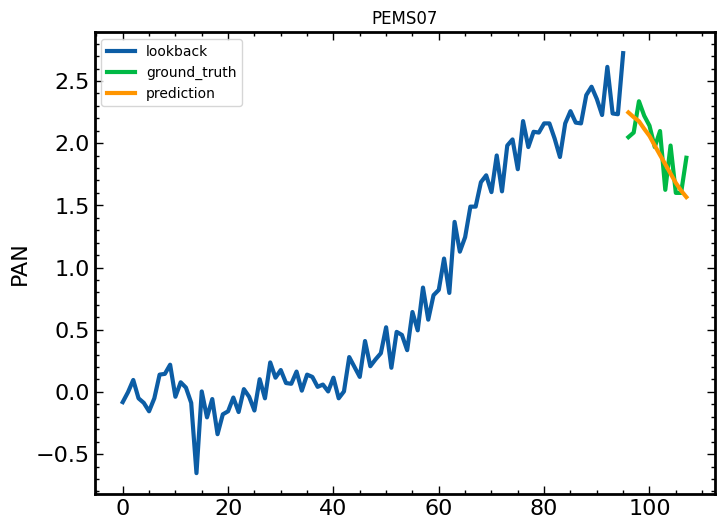

In [2]:


from src.experiments.shortterm import CiDPGForecast
dataset= "PEMS07"


exp = CiDPGForecast(dataset_type=dataset, windows=96, pred_len=12, data_path='/notebooks/4901_revisit_cdtran/data', save_dir='/notebooks/4901_revisit_cdtran/results', device='cuda:0')
exp._setup_run(1)
exp._resume_run(1)



# i = 10 # usable v=0
i = 1020
b = 0
v = 580 #b500

batch_x, batch_y, origin_x, origin_y, batch_x_date_enc, batch_y_date_enc = map(lambda x: torch.tensor(x).to(exp.device).unsqueeze(0).float(),  exp.dataloader.test_loader.dataset[i])
pred_y, true_y  = exp._process_one_batch(batch_x, batch_y, batch_x_date_enc, batch_y_date_enc)



plot_x = batch_x[b, :, v].cpu().detach().numpy()
plot_y = batch_y[b, :, v].cpu().detach().numpy()
plot_pred_y = pred_y[b, :, v].cpu().detach().numpy()


x_ticks = np.arange(len(plot_x))
y_ticks = np.arange(len(plot_x), len(plot_x)+len(plot_y))


plt.show()
pred_y, true_y  = exp._process_one_batch(batch_x, batch_y, batch_x_date_enc, batch_y_date_enc)
plot_pred_y = pred_y[b, :, v].cpu().detach().numpy()
xy_plot(plot_x, plot_y, plot_pred_y, 'PEMS07', 'PAN')

plt.show()


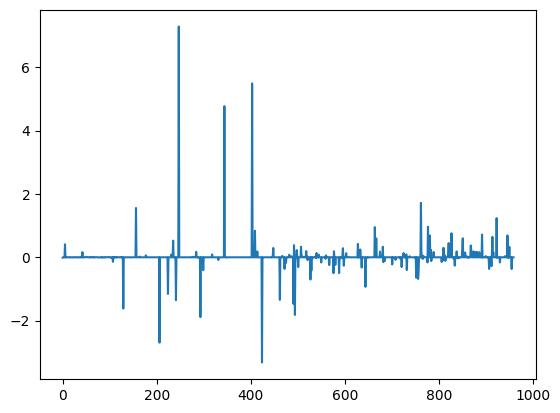

In [38]:

exp.model.init_embedding[0].shape
# exp.model.prevs[0][0, 580, :]
exp.model.init_embedding[0][v, :]
plt.plot(alle[v].detach().cpu().numpy())

In [31]:
import seaborn as sns
# sns.heatmap(exp.model.init_embedding[0].detach().cpu().numpy())

alle = torch.concat([exp.model.init_embedding[0], exp.model.prevs[0][0], exp.model.prevs[1][0]], dim=1)
# sns.heatmap(exp.model.prevs[1][0, [v, v+1], :].detach().cpu().numpy())

sns.heatmap(alle[v].detach().cpu().numpy())

IndexError: Inconsistent shape between the condition and the input (got (960, 1) and (960,))

In [28]:
exp.model.init_embedding[0][0].shape

torch.Size([128])

In [40]:
alle[v].shape

torch.Size([960])

In [47]:
alle[[v,v+1], :].shape

torch.Size([2, 960])

<Axes: >

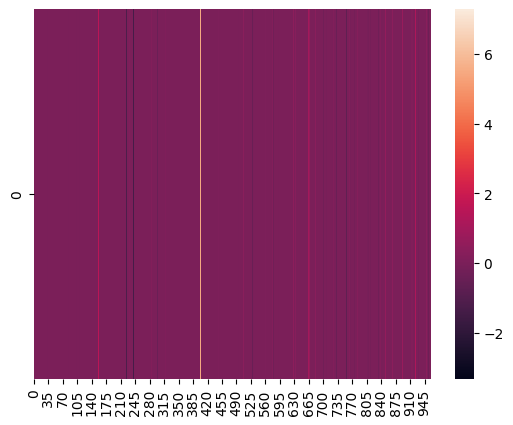

In [61]:
sns.heatmap(alle[[v], :].detach().cpu().numpy())


## Case Study

### ExchangeRate

In [9]:
dataset= "ExchangeRate"


In [10]:
from torch_timeseries.experiments import DLinearForecast, PatchTSTForecast

exp = DLinearForecast(dataset_type=dataset, windows=336, pred_len=720, data_path='/notebooks/pytorchtimseries/data', save_dir='/notebooks/pytorchtimseries/results', device='cuda:0')
exp._setup_run(1)
exp._resume_run(1)

# i = 1000
i = 0
batch_x, batch_y, origin_x, origin_y, batch_x_date_enc, batch_y_date_enc = map(lambda x: torch.tensor(x).to(exp.device).unsqueeze(0).float(),  exp.dataloader.test_loader.dataset[i])
pred_y, true_y  = exp._process_one_batch(batch_x, batch_y, batch_x_date_enc, batch_y_date_enc)


b = 0
v = 5

plot_x = batch_x[b, :, v].cpu().detach().numpy()
plot_y = batch_y[b, :, v].cpu().detach().numpy()
plot_pred_y = pred_y[b, :, v].cpu().detach().numpy()


x_ticks = np.arange(len(plot_x))
y_ticks = np.arange(len(plot_x), len(plot_x)+len(plot_y))

Using downloaded and verified file: /notebooks/pytorchtimseries/data/ExchangeRate/exchange_rate.csv
train steps: 4256
val steps: 798
test steps: 41


/root/anaconda3/envs/testpyt/lib/python3.8/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/root/anaconda3/envs/testpyt/lib/python3.8/site-packages/torch/__init__.py:955: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)
/root/anaconda3/envs/testpyt/lib/python3.8/site-packages/torch_timeseries-0.1.5-py3.8.egg/torch_timeseries/experiments/forecast.py:378: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future

resuming from /notebooks/pytorchtimseries/results/runs/DLinear/ExchangeRate/w336h1s720/48211ee8be1f7a195b8e7f39bec77c02/run_checkpoint.pth


In [11]:
from src.experiments.CiDPG import CiDPGForecast

exp = CiDPGForecast(dataset_type=dataset, windows=336, horizon=1, pred_len=720, data_path='/notebooks/pytorchtimseries/data', save_dir='/notebooks/4901_revisit_cdtran/results', device='cuda:0')
exp._setup_run(1)
exp._resume_run(1)

# batch_x, batch_y, origin_x, origin_y, batch_x_date_enc, batch_y_date_enc = map(lambda x: x.to(exp.device).float(), next(iter(exp.test_loader)))
pred_y, true_y  = exp._process_one_batch(batch_x, batch_y, batch_x_date_enc, batch_y_date_enc)
plot_pred_y = pred_y[b, :, v].cpu().detach().numpy()


Using downloaded and verified file: /notebooks/pytorchtimseries/data/ExchangeRate/exchange_rate.csv
train steps: 4256
val steps: 798
test steps: 41
tensor([128, 182, 238, 292, 348, 402, 458, 512], dtype=torch.int32)
self.t_index [95, 143, 191, 239, 287, 335, 383]
resuming from /notebooks/4901_revisit_cdtran/results/runs/CiDPG/ExchangeRate/w336h1s720/b5d8417215bf20d2f9e7ac6b5f0691fd/run_checkpoint.pth


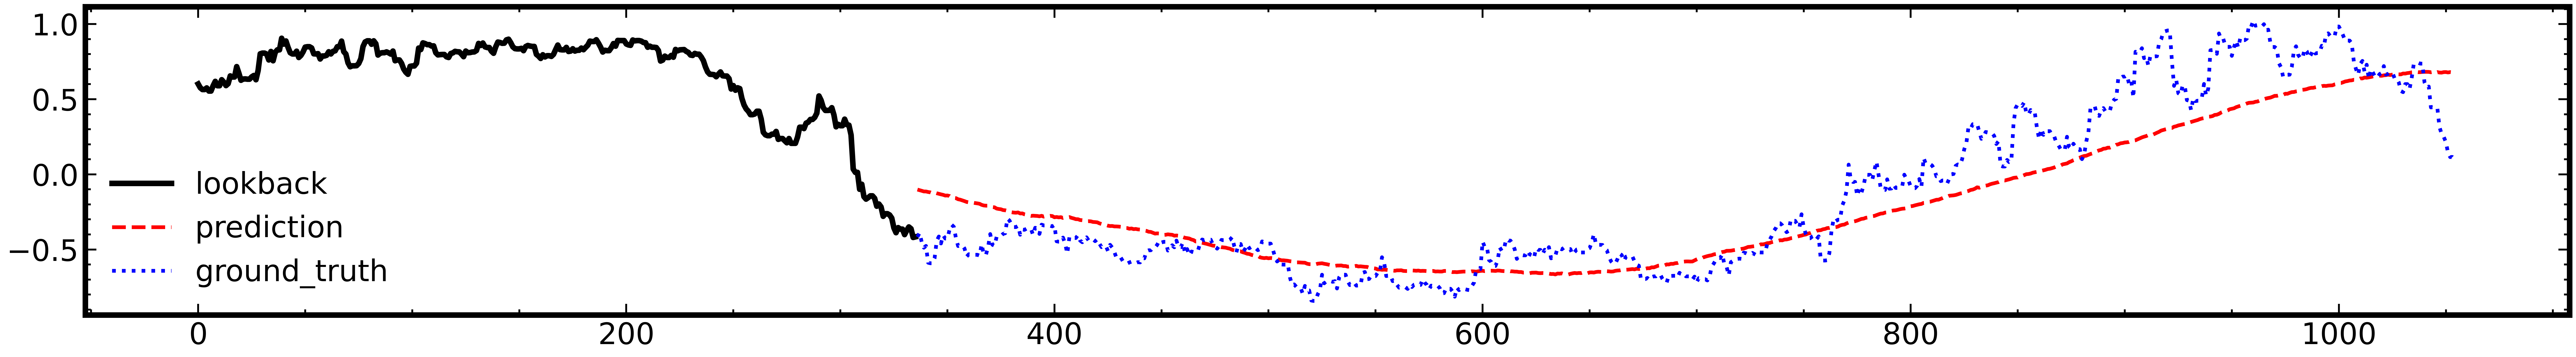

In [67]:

plt.figure(figsize=(24,3))
plt.plot(x_ticks, plot_x, label='lookback', linewidth=3)
# 设置图表边框的粗细
for spine in plt.gca().spines.values():
    spine.set_linewidth(3)

plt.plot(y_ticks, plot_pred_y, label='prediction')
plt.plot(y_ticks, plot_y, label='ground_truth')
plt.legend()
# plot_pred_y = pred_y[b, :, :].cpu().detach().numpy()
# plt.plot(x_ticks, batch_x[0].cpu().detach().numpy(), label='lookback')
# plt.plot(y_ticks, batch_y[0].cpu().detach().numpy(), label='ground_truth')
# plt.plot(y_ticks, plot_pred_y, label='prediction')
# pred_y, true_y  = exp._process_one_batch(batch_x, batch_y, batch_x_date_enc, batch_y_date_enc)
# plot_pred_y = pred_y[b, :, v].cpu().detach().numpy()
# xy_plot(plot_x, plot_y, plot_pred_y, 'PEMS07', 'PAN')
plt.savefig('./a.svg')

plt.show()
# plt.savefig('./a.svg')


In [12]:
vi = 0
plot_x = batch_x[b, :, vi].cpu().detach().numpy()
plot_y = batch_y[b, :, vi].cpu().detach().numpy()
plot_pred_y = pred_y[b, :, vi].cpu().detach().numpy()




### TSNE

(8, 512)

In [28]:
from sklearn.preprocessing import pad_sequences

inp = exp.model.prevs[0][0].detach().cpu().numpy()
target_length = exp.model.prevs[-1][0].shape[1]
inps = [ np.pad(p[0].detach().cpu().numpy(), (0, p[0].detach().cpu().numpy().shape[1]), mode='constant') for p in  exp.model.prevs ]
# np.pad(data, (0, target_length - len(data)), mode='constant', constant_values=padding_value)


ImportError: cannot import name 'pad_sequences' from 'sklearn.preprocessing' (/root/anaconda3/envs/testpyt/lib/python3.8/site-packages/sklearn/preprocessing/__init__.py)

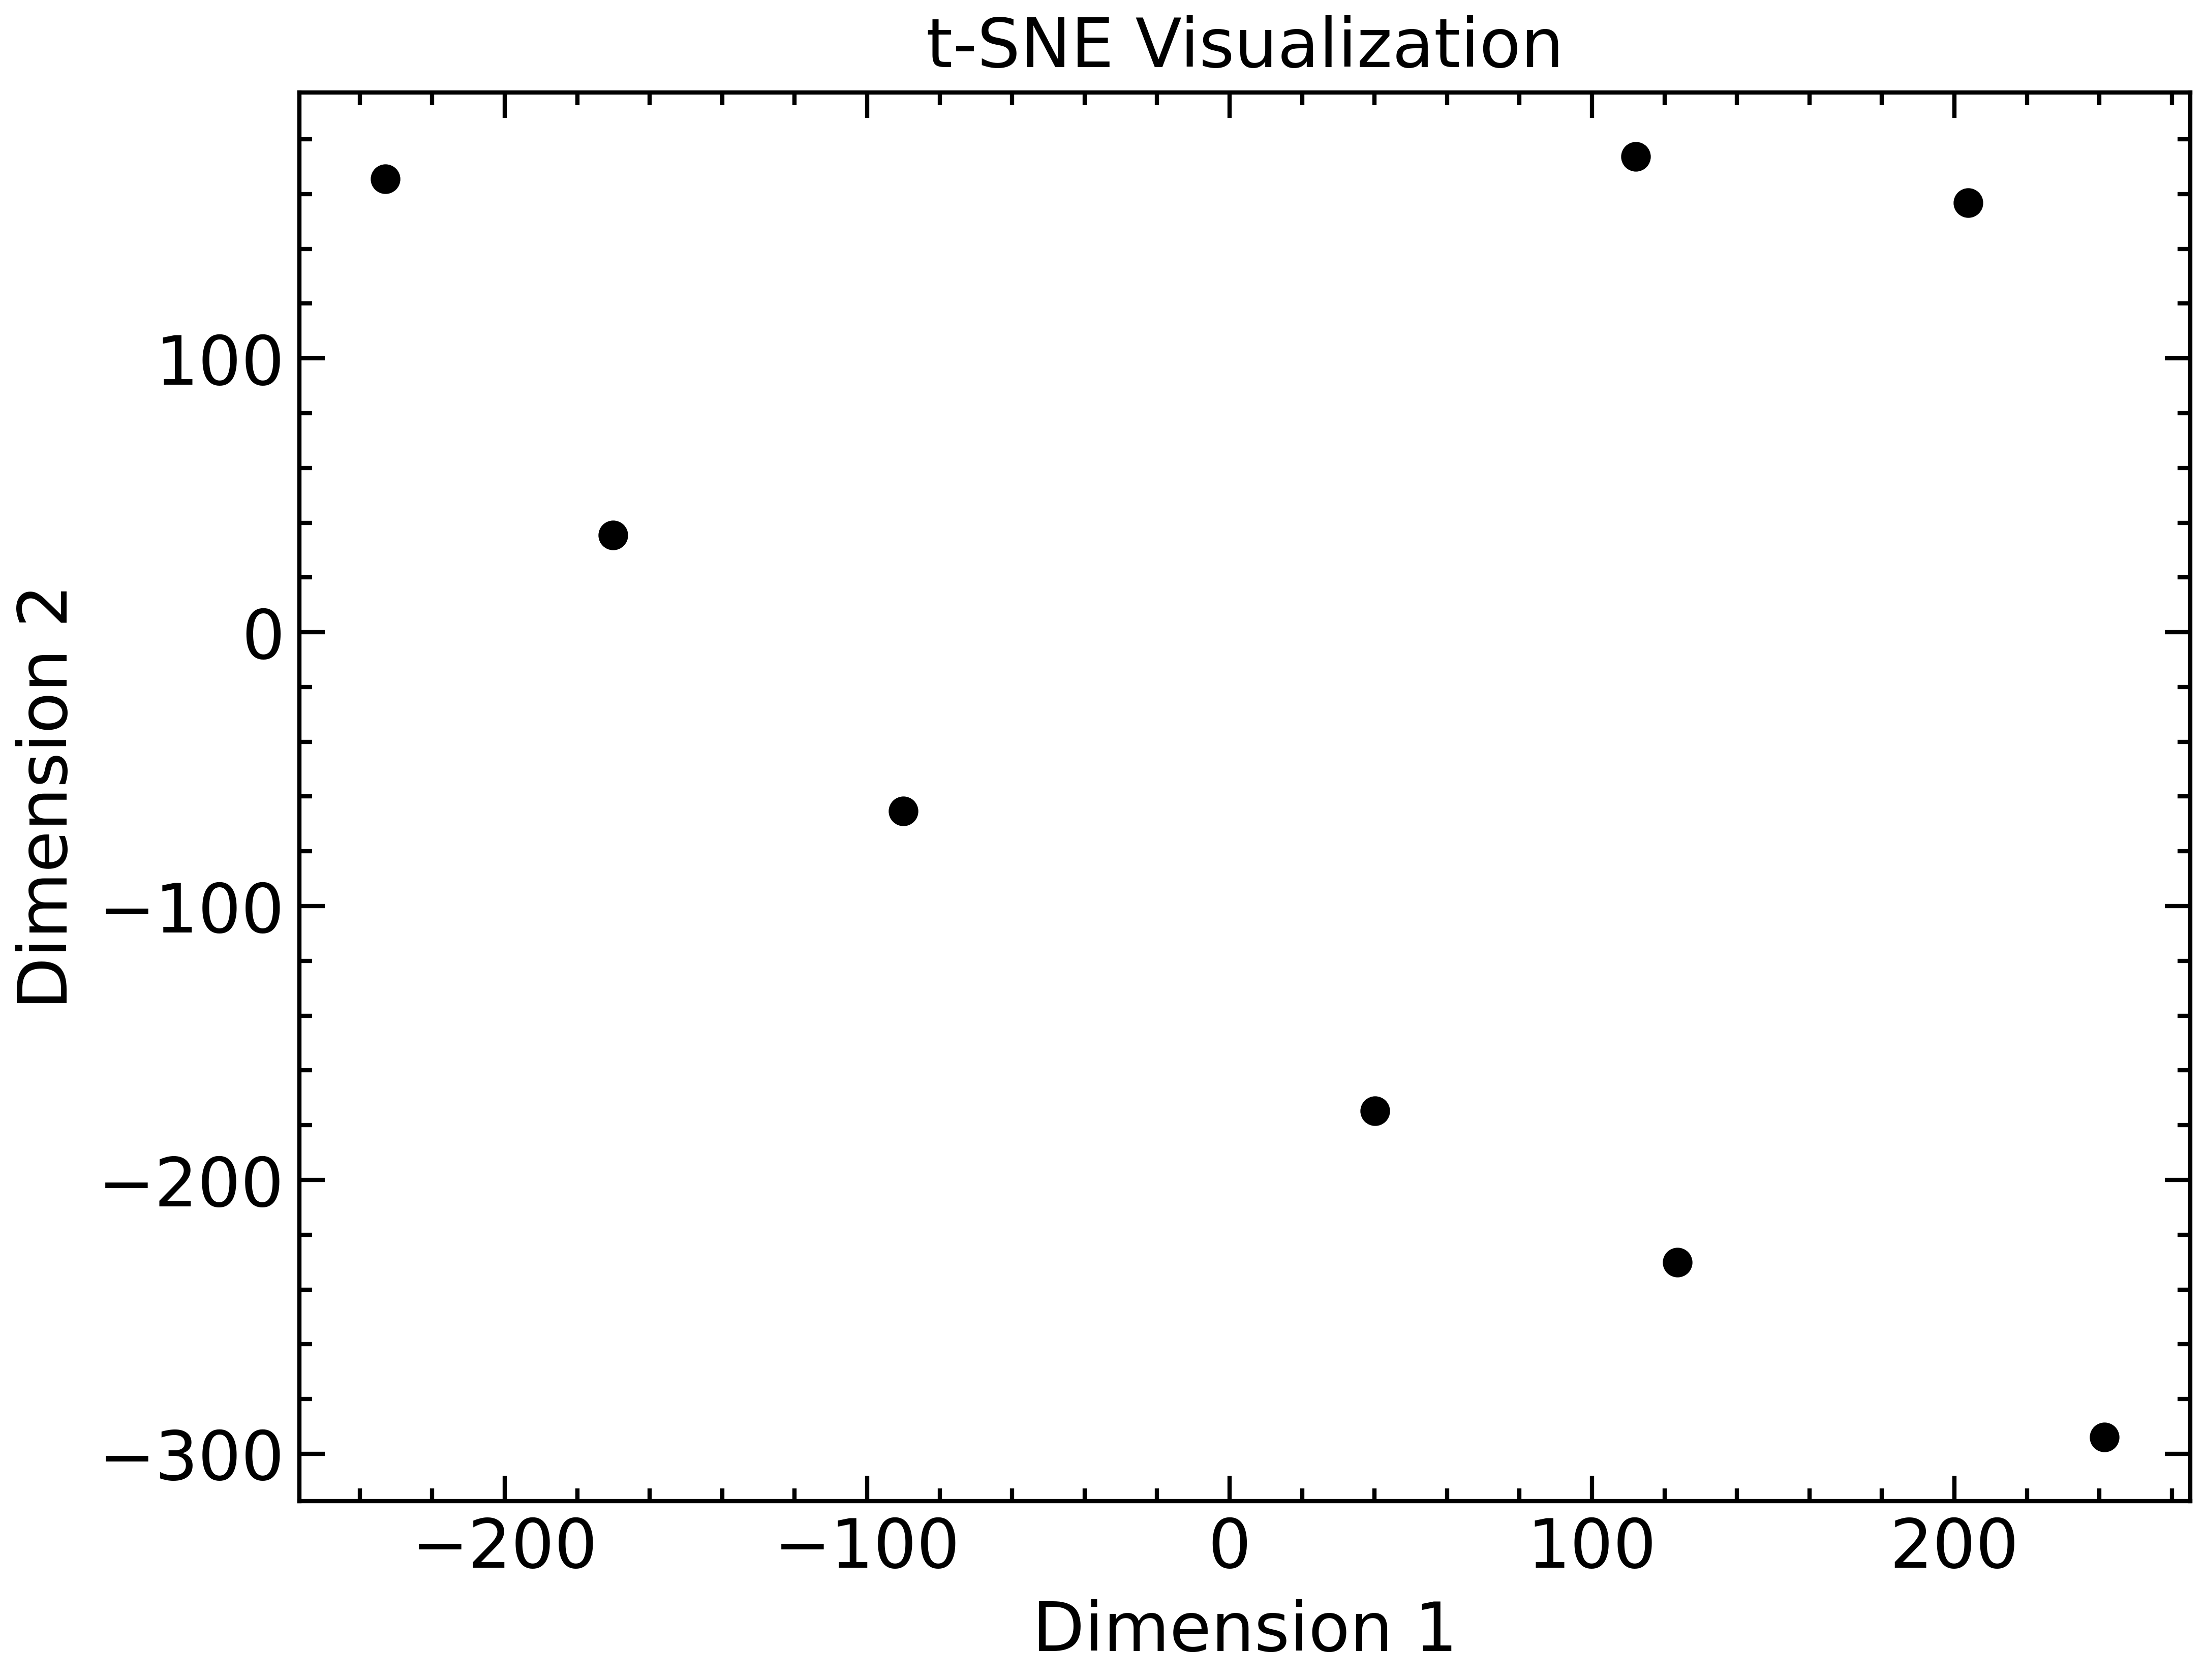

In [20]:

import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42,perplexity=2)
low_dim_data = tsne.fit_transform(inp)

# 可视化
plt.scatter(low_dim_data[:, 0], low_dim_data[:, 1])
plt.title('t-SNE Visualization')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

In [10]:

alle = torch.concat([exp.model.init_embedding[0], exp.model.prevs[0][0], exp.model.prevs[1][0]], dim=1)
# sns.heatmap(exp.model.prevs[1][0, [v, v+1], :].detach().cpu().numpy())
with plt.style.context(['science', 'notebook']):
    # sns.heatmap( exp.model.prevs[0][0].detach().cpu().numpy(), cbar=False, xticklabels=False, yticklabels=False)
    sns.heatmap( exp.model.prevs[0][0].detach().cpu().numpy(), xticklabels=False)

NameError: name 'sns' is not defined

In [135]:
exp.model.prevs[6][0].shape

torch.Size([8, 512])

In [76]:
torch.nn.functional.pad(batch_x, (48, 0)).shape

torch.Size([1, 336, 56])

In [73]:
exp.model.t_index

[95, 143, 191, 239, 287, 335, 383]

In [137]:
prevs = [p for p in exp.model.prevs]

torch.Size([512])

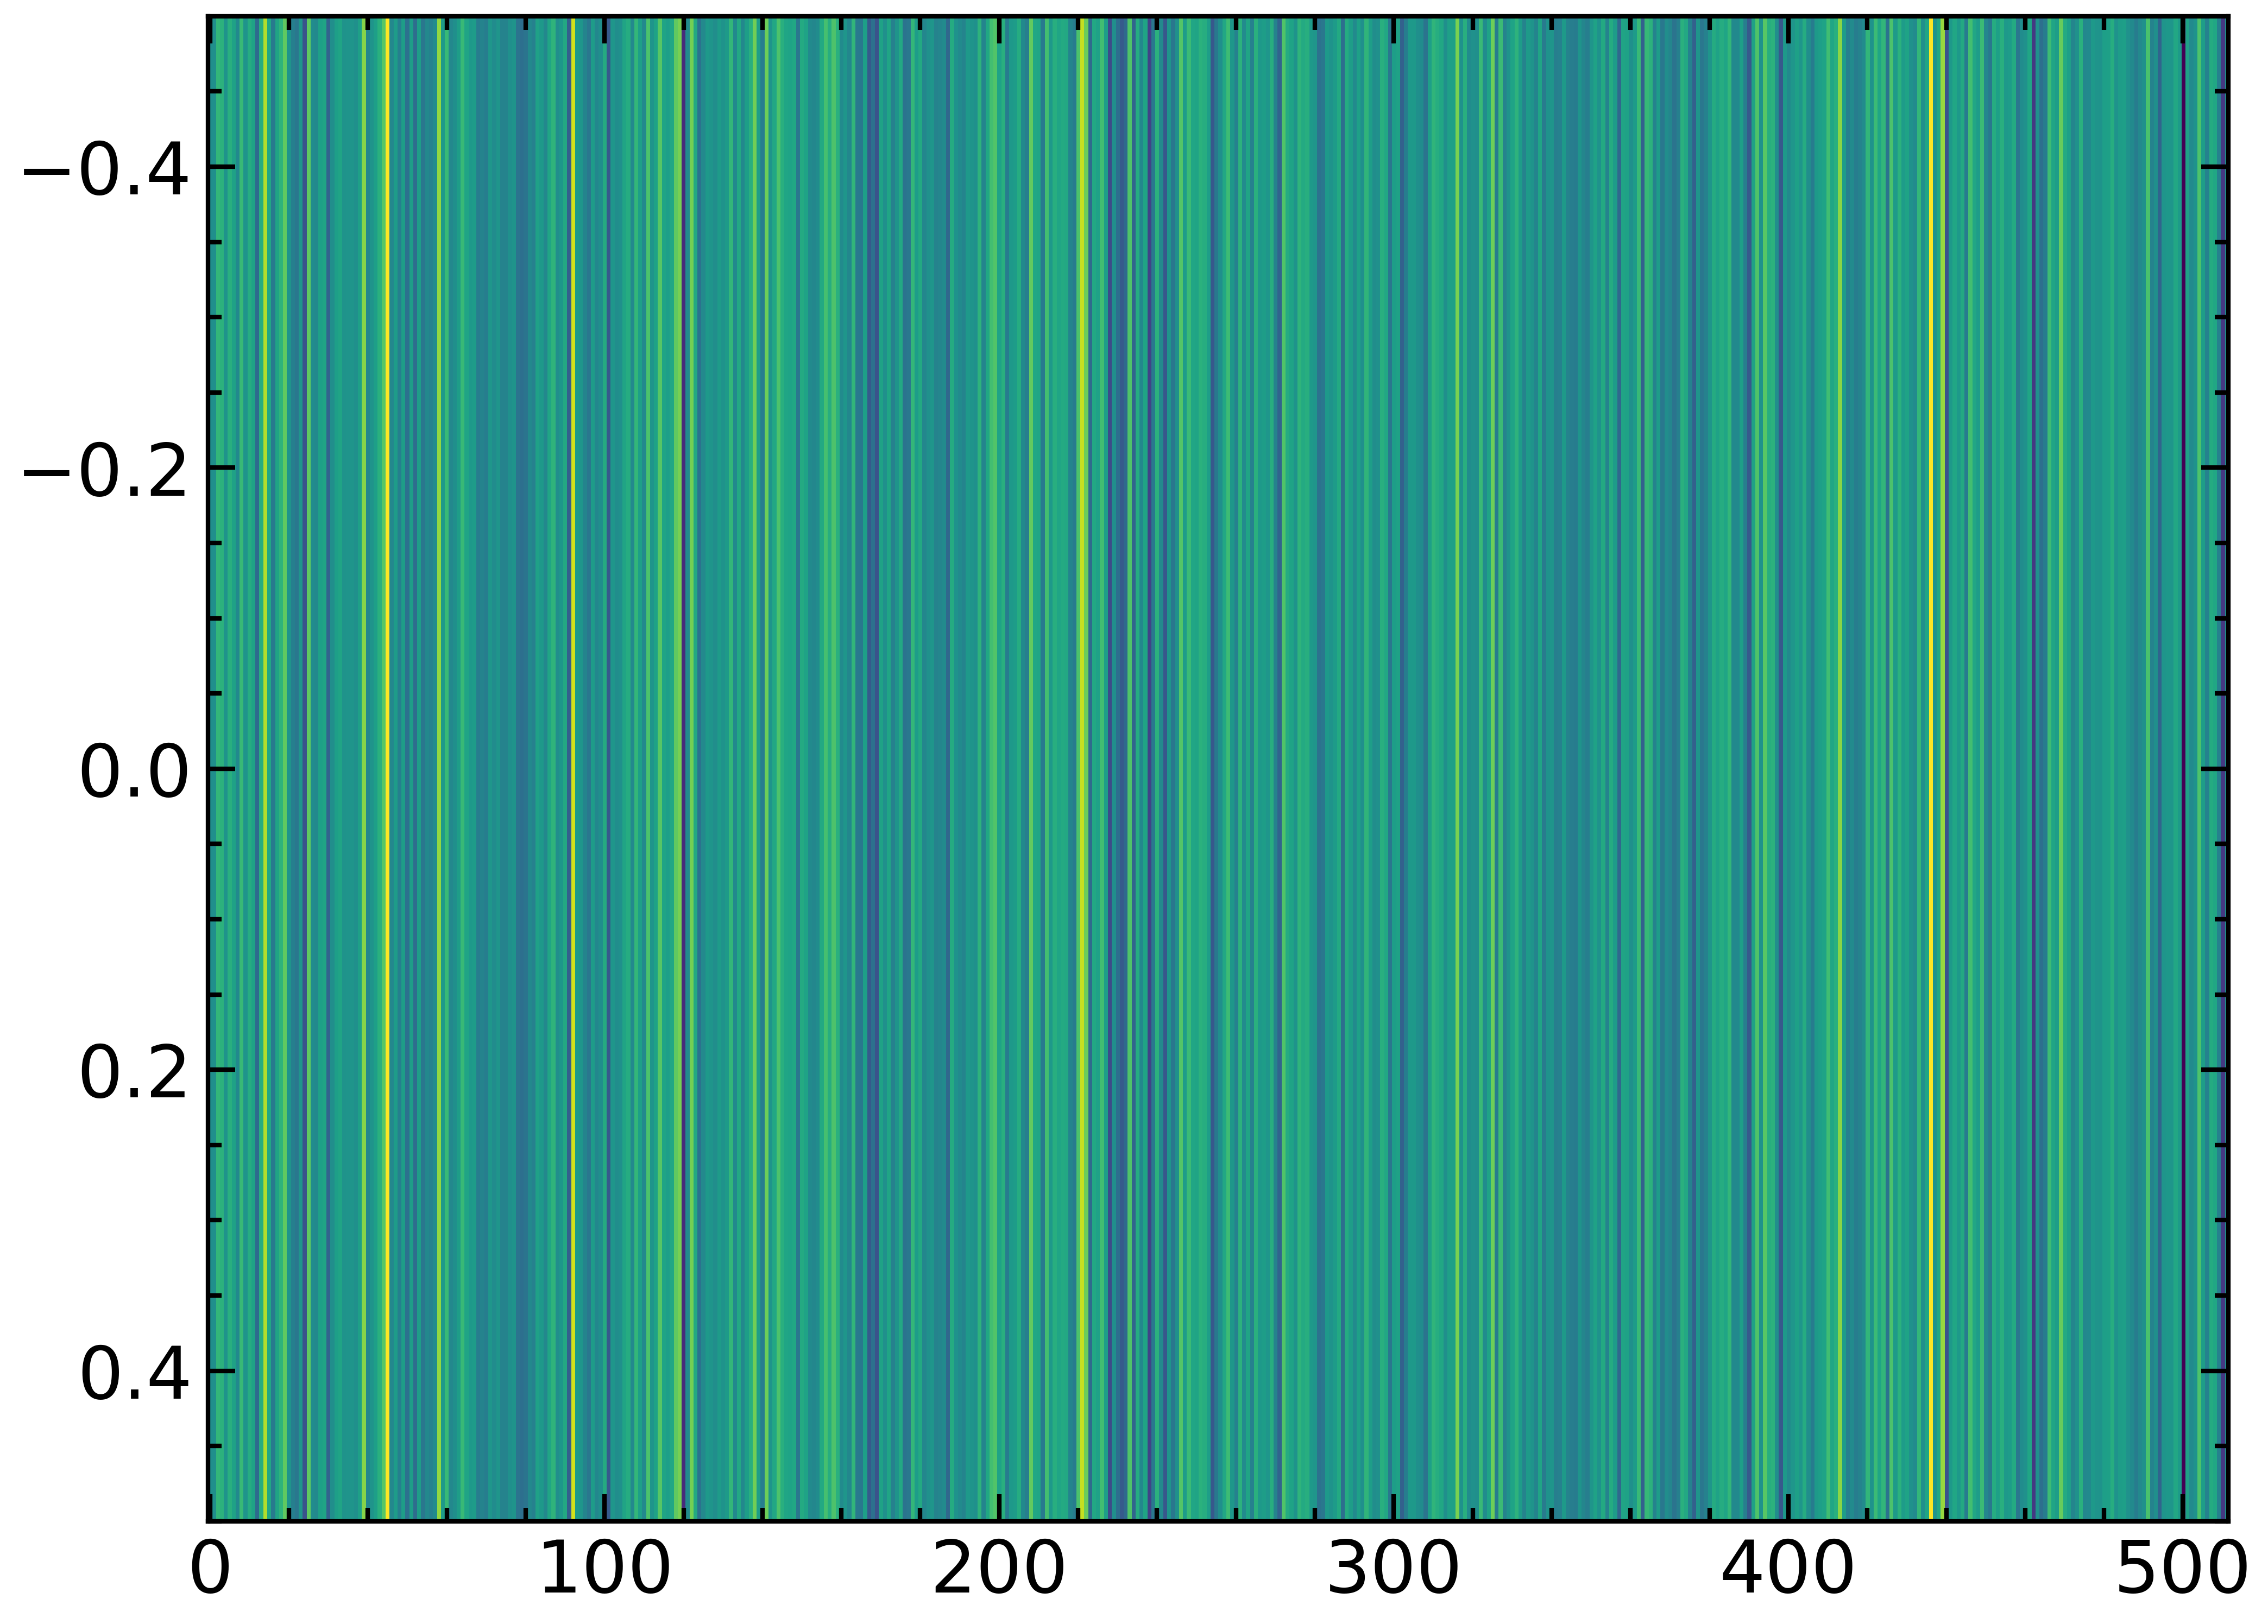

In [70]:
plt.imshow( exp.model.prevs[6][0][v].unsqueeze(0).detach().cpu().numpy(), cmap='viridis', aspect='auto')  # 选择适合的 colormap


In [4]:
from sklearn.metrics.pairwise import linear_kernel
from scipy.linalg import svd

from sklearn.metrics.pairwise import linear_kernel

# X 和 Y 的维度可以不一样
# K = linear_kernel(X, X)  # K: n x n
# L = linear_kernel(Y, Y)  # L: n x n

def center_kernel(K):
    n = K.shape[0]
    H = np.eye(n) - np.ones((n, n)) / n
    return H @ K @ H

def compute_cka(X, Y):
    K = linear_kernel(X, X)
    L = linear_kernel(Y, Y)
    
    K_c = center_kernel(K)
    L_c = center_kernel(L)
    
    hsic = np.trace(K_c @ L_c)
    norm_k = np.trace(K_c @ K_c)
    norm_l = np.trace(L_c @ L_c)
    
    return hsic / np.sqrt(norm_k * norm_l)

# cka_score = compute_cka(exp.model.prevs[6][0].detach().cpu().numpy(), batch_y[0].transpose(0,1).detach().cpu().numpy())
cka_score0 = compute_cka(exp.model.init_embedding[0].detach().cpu().numpy(), batch_y[0].transpose(0,1).detach().cpu().numpy())
cka_score1 = compute_cka(exp.model.prevs[5][0].detach().cpu().numpy(), batch_y[0].transpose(0,1).detach().cpu().numpy())
cka_score1 = compute_cka(exp.model.prevs[5][0].detach().cpu().numpy(), batch_y[0].transpose(0,1).detach().cpu().numpy())


In [173]:
for i in range(0, 7):
    # print(compute_cka(exp.model.prevs[0][0].detach().cpu().numpy(), exp.model.prevs[i][0].detach().cpu().numpy()))
    # print(compute_cka(exp.model.prevs[0][0].detach().cpu().numpy(), exp.model.prevs[i][0].detach().cpu().numpy()))
    print(compute_cka(standardize(batch_y[0].transpose(0,1).detach().cpu().numpy()) , exp.model.prevs[i][0].detach().cpu().numpy()))
    
    # exp.model.init_embedding[0]
    

0.5070225884442033
0.44675735936343003
0.4202179492269441
0.40481838268381093
0.37674140633167524
0.36663830022487043
0.5522921822068216


In [171]:
X, Y = exp.model.prevs[6][0].detach().cpu().numpy(),batch_y[0].transpose(0,1).detach().cpu().numpy()

In [172]:
def standardize(X):
    mean_vals = X.mean(axis=1, keepdims=True)
    std_vals = X.std(axis=1, keepdims=True)
    return (X - mean_vals) / (std_vals + 1e-8)  # 避免除以零

def rv_coefficient(X, Y):
    numerator = np.trace(X @ X.T @ Y @ Y.T)
    denominator = np.sqrt(np.trace((X @ X.T) ** 2) * np.trace((Y @ Y.T) ** 2))
    return numerator / denominator

similarity = rv_coefficient(X, standardize(Y))
print("RV Coefficient:", similarity)


RV Coefficient: 2.6247466


In [169]:
Y.shape

(8, 720)

## Representation

### ETTh1

In [3]:
dataset = 'ETTh1'

In [4]:
from torch_timeseries.experiments import DLinearForecast, PatchTSTForecast

from src.experiments.CiDPG import CiDPGForecast

exp = CiDPGForecast(dataset_type=dataset, windows=336, horizon=1, pred_len=720, data_path='/notebooks/pytorchtimseries/data', save_dir='/notebooks/4901_revisit_cdtran/results', device='cuda:0')
exp._setup_run(1)
exp._resume_run(1)


plt.show()

# i = 1000
i = 0
batch_x, batch_y, origin_x, origin_y, batch_x_date_enc, batch_y_date_enc = map(lambda x: torch.tensor(x).to(exp.device).unsqueeze(0).float(),  exp.dataloader.test_loader.dataset[i])
pred_y, true_y  = exp._process_one_batch(batch_x, batch_y, batch_x_date_enc, batch_y_date_enc)


b = 0
v = 0

plot_x = batch_x[b, :, v].cpu().detach().numpy()
plot_y = batch_y[b, :, v].cpu().detach().numpy()
plot_pred_y = pred_y[b, :, v].cpu().detach().numpy()

x_ticks = np.arange(len(plot_x))
y_ticks = np.arange(len(plot_x), len(plot_x)+len(plot_y))

xy_plot

ModuleNotFoundError: No module named 'src'

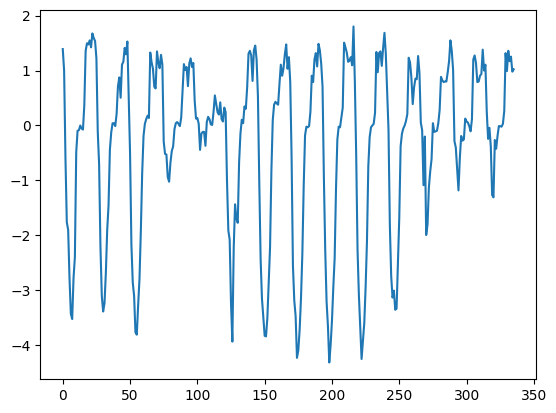

In [181]:
from src.experiments.CiDPG import CiDPGForecast
plt.plot(x_ticks, plot_x, label='lookback')
# plt.plot(y_ticks, plot_y, label='ground_truth')
# plt.plot(y_ticks, plot_pred_y, label='prediction')
plt.show()


In [180]:
for i in range(0, 7):
    # print(compute_cka(exp.model.prevs[0][0].detach().cpu().numpy(), exp.model.prevs[i][0].detach().cpu().numpy()))
    print(compute_cka(exp.model.prevs[0][0].detach().cpu().numpy(), exp.model.prevs[i][0].detach().cpu().numpy()), 
          compute_cka(standardize(batch_y[0].transpose(0,1).detach().cpu().numpy()) , exp.model.prevs[i][0].detach().cpu().numpy()))
    
    # exp.model.init_embedding[0]
    

1.0 0.6726167160796801
0.9211184884111563 0.5908949644898076
0.8348669273726101 0.5480234163070126
0.8168922848634003 0.4975571575598399
0.7883129748749167 0.5865042644773983
0.9498860396955562 0.7115725605854225
0.8088318286757638 0.9096738138424695


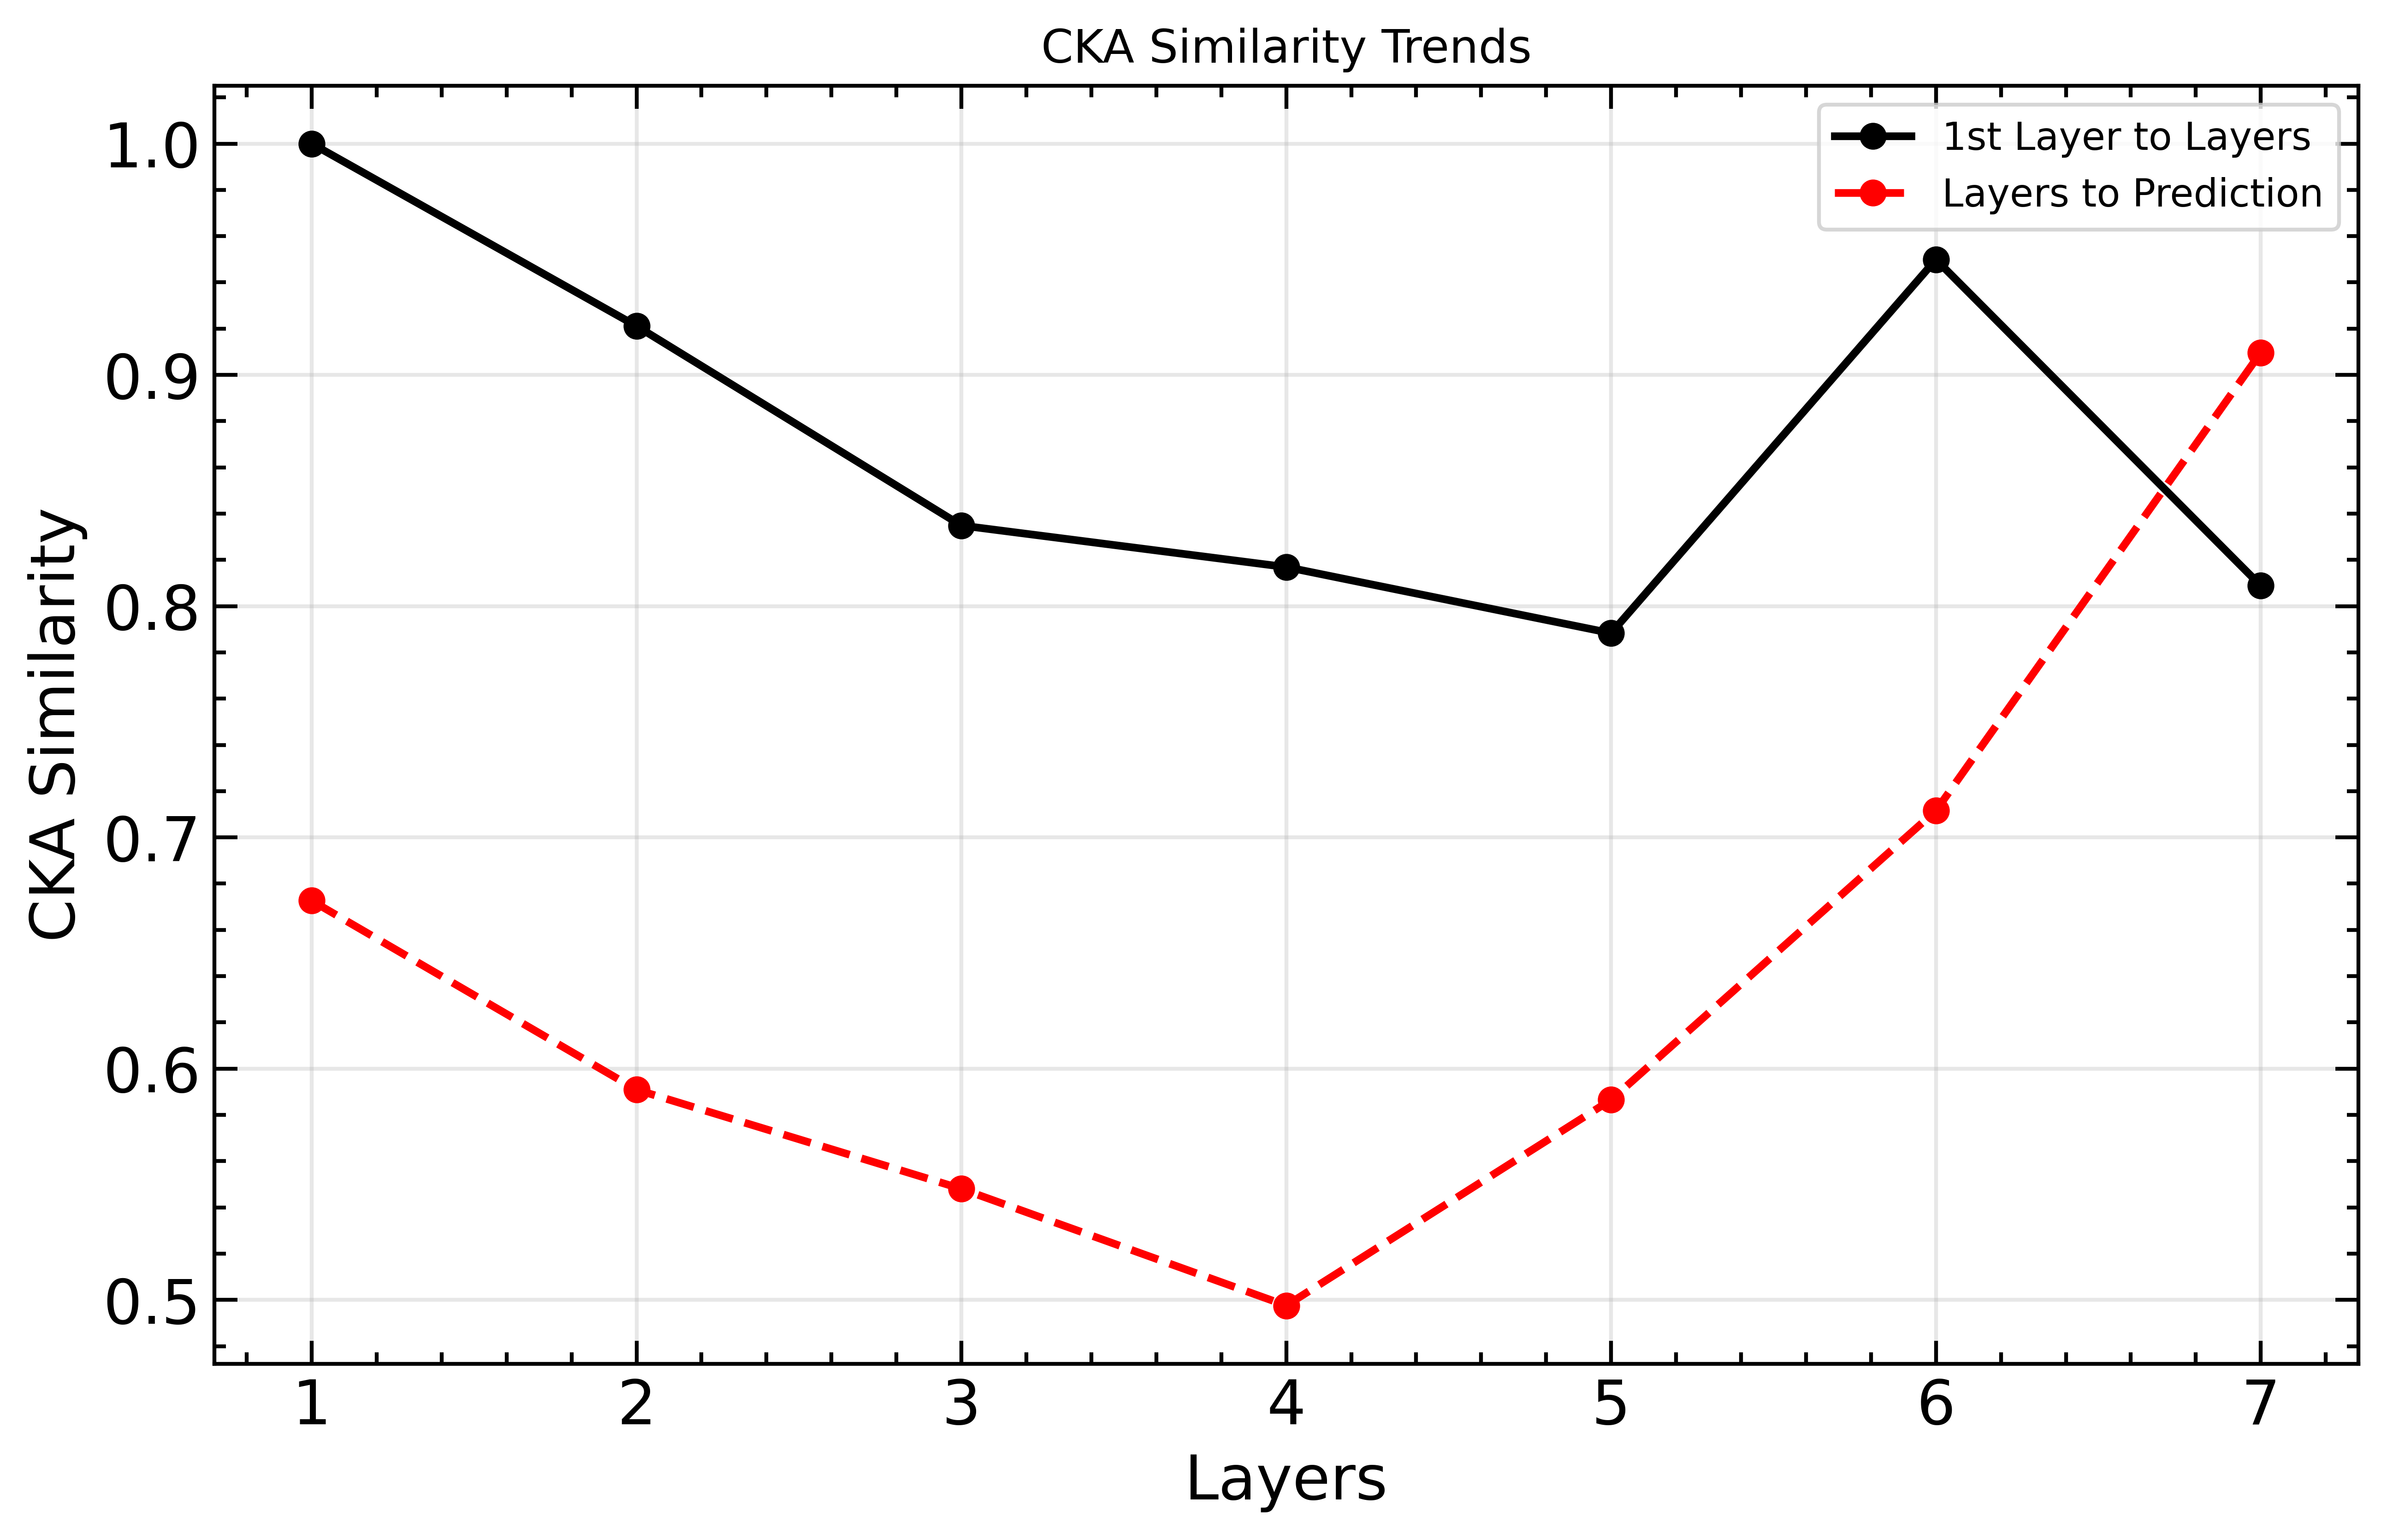

In [16]:
import matplotlib.pyplot as plt

# Data
x = list(range(1, 8))  # Line numbers for x-axis
first_layer_to_layers = [1.0, 0.9211184884111563, 0.8348669273726101, 0.8168922848634003, 0.7883129748749167, 0.9498860396955562, 0.8088318286757638]
first_layer_to_y = [0.6726167160796801, 0.5908949644898076, 0.5480234163070126, 0.4975571575598399, 0.5865042644773983, 0.7115725605854225, 0.9096738138424695]

with plt.style.context(['science', 'ieee', 'notebook']):
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(x, first_layer_to_layers, label="1st Layer to Layers", marker='o')
    plt.plot(x, first_layer_to_y, label="Layers to Prediction", marker='o')

# Adding labels and title
plt.xlabel("Layers")
plt.ylabel("CKA Similarity")
plt.title("CKA Similarity Trends")
plt.legend()
plt.grid(alpha=0.3)

# Display
plt.show()


### ETTh2

In [182]:
dataset = "ETTh2"

In [183]:
from torch_timeseries.experiments import DLinearForecast, PatchTSTForecast

from src.experiments.CiDPG import CiDPGForecast

exp = CiDPGForecast(dataset_type=dataset, windows=336, horizon=1, pred_len=720, data_path='/notebooks/pytorchtimseries/data', save_dir='/notebooks/4901_revisit_cdtran/results', device='cuda:0')
exp._setup_run(1)
exp._resume_run(1)


plt.show()

# i = 1000
i = 0
batch_x, batch_y, origin_x, origin_y, batch_x_date_enc, batch_y_date_enc = map(lambda x: torch.tensor(x).to(exp.device).unsqueeze(0).float(),  exp.dataloader.test_loader.dataset[i])
pred_y, true_y  = exp._process_one_batch(batch_x, batch_y, batch_x_date_enc, batch_y_date_enc)


b = 0
v = 0

plot_x = batch_x[b, :, v].cpu().detach().numpy()
plot_y = batch_y[b, :, v].cpu().detach().numpy()
plot_pred_y = pred_y[b, :, v].cpu().detach().numpy()

x_ticks = np.arange(len(plot_x))
y_ticks = np.arange(len(plot_x), len(plot_x)+len(plot_y))

# xy_plot

Using downloaded and verified file: /notebooks/pytorchtimseries/data/ETTh2/ETTh2.csv
train steps: 11139
val steps: 2765
test steps: 1023
tensor([128, 182, 238, 292, 348, 402, 458, 512], dtype=torch.int32)
self.t_index [95, 143, 191, 239, 287, 335, 383]
resuming from /notebooks/4901_revisit_cdtran/results/runs/CiDPG/ETTh2/w336h1s720/70b484dd56514da8a0c5365974b923bb/run_checkpoint.pth


/notebooks/pytorchtimseries/torch_timeseries/experiments/forecast.py:378: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  check_point = torch.load(run_checkpoint_filepath, map

<function __main__.xy_plot(x, y, pred_y, title=None, y_label=None)>

In [184]:
for i in range(0, 7):
    # print(compute_cka(exp.model.prevs[0][0].detach().cpu().numpy(), exp.model.prevs[i][0].detach().cpu().numpy()))
    print(compute_cka(exp.model.prevs[0][0].detach().cpu().numpy(), exp.model.prevs[i][0].detach().cpu().numpy()), 
          compute_cka(standardize(batch_y[0].transpose(0,1).detach().cpu().numpy()) , exp.model.prevs[i][0].detach().cpu().numpy()))
    
    # exp.model.init_embedding[0]
    

1.0 0.6393106702014503
0.9532140433120384 0.5971223414449202
0.9385903096577748 0.6926729714262925
0.9058354512562704 0.7546694427244285
0.8847435128425178 0.8079246206545276
0.9222705284260281 0.7044103794533159
0.6706138987453633 0.756887103452439


### ETTm1

In [185]:
dataset = "ETTm1"
from torch_timeseries.experiments import DLinearForecast, PatchTSTForecast

from src.experiments.CiDPG import CiDPGForecast

exp = CiDPGForecast(dataset_type=dataset, windows=336, horizon=1, pred_len=720, data_path='/notebooks/pytorchtimseries/data', save_dir='/notebooks/4901_revisit_cdtran/results', device='cuda:0')
exp._setup_run(1)
exp._resume_run(1)


plt.show()

# i = 1000
i = 0
batch_x, batch_y, origin_x, origin_y, batch_x_date_enc, batch_y_date_enc = map(lambda x: torch.tensor(x).to(exp.device).unsqueeze(0).float(),  exp.dataloader.test_loader.dataset[i])
pred_y, true_y  = exp._process_one_batch(batch_x, batch_y, batch_x_date_enc, batch_y_date_enc)


b = 0
v = 0

plot_x = batch_x[b, :, v].cpu().detach().numpy()
plot_y = batch_y[b, :, v].cpu().detach().numpy()
plot_pred_y = pred_y[b, :, v].cpu().detach().numpy()

x_ticks = np.arange(len(plot_x))
y_ticks = np.arange(len(plot_x), len(plot_x)+len(plot_y))

# xy_plot

Using downloaded and verified file: /notebooks/pytorchtimseries/data/ETTm1/ETTm1.csv
train steps: 47721
val steps: 13217
test steps: 6249
tensor([128, 182, 238, 292, 348, 402, 458, 512], dtype=torch.int32)
self.t_index [95, 143, 191, 239, 287, 335, 383]
resuming from /notebooks/4901_revisit_cdtran/results/runs/CiDPG/ETTm1/w336h1s720/7acdbe83733deb64baae5651bbbcfbcf/run_checkpoint.pth


/notebooks/pytorchtimseries/torch_timeseries/experiments/forecast.py:378: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  check_point = torch.load(run_checkpoint_filepath, map

In [186]:
for i in range(0, 7):
    # print(compute_cka(exp.model.prevs[0][0].detach().cpu().numpy(), exp.model.prevs[i][0].detach().cpu().numpy()))
    print(compute_cka(exp.model.prevs[0][0].detach().cpu().numpy(), exp.model.prevs[i][0].detach().cpu().numpy()), 
          compute_cka(standardize(batch_y[0].transpose(0,1).detach().cpu().numpy()) , exp.model.prevs[i][0].detach().cpu().numpy()))
    
    # exp.model.init_embedding[0]
    
    

1.0 0.46618016480748914
0.9319610196292578 0.541110819603167
0.7210298650602122 0.6753151077053451
0.7709363933995932 0.790844910418796
0.7167497340622673 0.7402117478101599
0.7943135921221114 0.8183922090962313
0.5007708863459291 0.8583458947173959


### ETTm2

In [193]:
dataset = "ETTm2"
from torch_timeseries.experiments import DLinearForecast, PatchTSTForecast

from src.experiments.CiDPG import CiDPGForecast

exp = CiDPGForecast(dataset_type=dataset, windows=336, horizon=1, pred_len=720, data_path='/notebooks/pytorchtimseries/data', save_dir='/notebooks/4901_revisit_cdtran/results', device='cuda:0')
exp._setup_run(1)
exp._resume_run(1)


plt.show()

# i = 1000
i = 100
batch_x, batch_y, origin_x, origin_y, batch_x_date_enc, batch_y_date_enc = map(lambda x: torch.tensor(x).to(exp.device).unsqueeze(0).float(),  exp.dataloader.test_loader.dataset[i])
pred_y, true_y  = exp._process_one_batch(batch_x, batch_y, batch_x_date_enc, batch_y_date_enc)


b = 0
v = 2

plot_x = batch_x[b, :, v].cpu().detach().numpy()
plot_y = batch_y[b, :, v].cpu().detach().numpy()
plot_pred_y = pred_y[b, :, v].cpu().detach().numpy()

x_ticks = np.arange(len(plot_x))
y_ticks = np.arange(len(plot_x), len(plot_x)+len(plot_y))

# xy_plot

Using downloaded and verified file: /notebooks/pytorchtimseries/data/ETTm2/ETTm2.csv
train steps: 47721
val steps: 13217
test steps: 6249
tensor([128, 182, 238, 292, 348, 402, 458, 512], dtype=torch.int32)
self.t_index [95, 143, 191, 239, 287, 335, 383]
resuming from /notebooks/4901_revisit_cdtran/results/runs/CiDPG/ETTm2/w336h1s720/5d71c8e619e81c0dd8b86c6ce0f5493d/run_checkpoint.pth


/notebooks/pytorchtimseries/torch_timeseries/experiments/forecast.py:378: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  check_point = torch.load(run_checkpoint_filepath, map

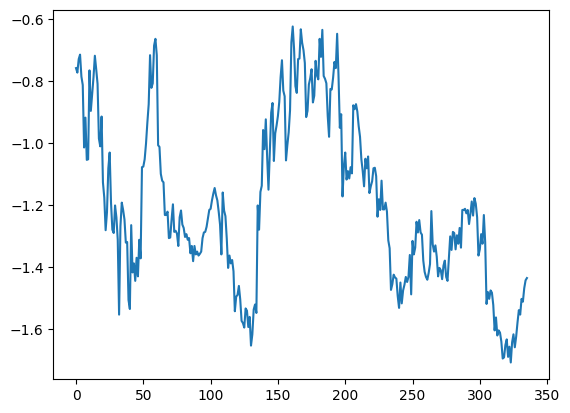

In [194]:
from src.experiments.CiDPG import CiDPGForecast
plt.plot(x_ticks, plot_x, label='lookback')
# plt.plot(y_ticks, plot_y, label='ground_truth')
# plt.plot(y_ticks, plot_pred_y, label='prediction')
plt.show()


In [195]:
for i in range(0, 7):
    # print(compute_cka(exp.model.prevs[0][0].detach().cpu().numpy(), exp.model.prevs[i][0].detach().cpu().numpy()))
    print(compute_cka(exp.model.prevs[0][0].detach().cpu().numpy(), exp.model.prevs[i][0].detach().cpu().numpy()), 
          compute_cka(standardize(batch_y[0].transpose(0,1).detach().cpu().numpy()) , exp.model.prevs[i][0].detach().cpu().numpy()))
    
    # exp.model.init_embedding[0]
    
    

1.0 0.0006236967937916374
0.974849363028893 0.009321159599221302
0.003019572611074733 0.5660322100189978
0.0037843846628097936 0.7096674937107577
0.004163882231675368 0.6361544725609665
0.015467545811714998 0.6876097433671953
-0.0008232508956227515 0.7751522448653254


### Electricity

In [196]:
dataset = "Electricity"
from torch_timeseries.experiments import DLinearForecast, PatchTSTForecast

from src.experiments.CiDPG import CiDPGForecast

exp = CiDPGForecast(dataset_type=dataset, windows=336, horizon=1, pred_len=720, data_path='/notebooks/pytorchtimseries/data', save_dir='/notebooks/4901_revisit_cdtran/results', device='cuda:0')
exp._setup_run(1)
exp._resume_run(1)


plt.show()

# i = 1000
i = 0
batch_x, batch_y, origin_x, origin_y, batch_x_date_enc, batch_y_date_enc = map(lambda x: torch.tensor(x).to(exp.device).unsqueeze(0).float(),  exp.dataloader.test_loader.dataset[i])
pred_y, true_y  = exp._process_one_batch(batch_x, batch_y, batch_x_date_enc, batch_y_date_enc)


b = 0
v = 0

plot_x = batch_x[b, :, v].cpu().detach().numpy()
plot_y = batch_y[b, :, v].cpu().detach().numpy()
plot_pred_y = pred_y[b, :, v].cpu().detach().numpy()

x_ticks = np.arange(len(plot_x))
y_ticks = np.arange(len(plot_x), len(plot_x)+len(plot_y))

# xy_plot

Using downloaded and verified file: /notebooks/pytorchtimseries/data/electricity/electricity.csv
train steps: 17357
val steps: 4541
test steps: 1913
tensor([128, 182, 238, 292, 348, 402, 458, 512], dtype=torch.int32)
self.t_index [95, 143, 191, 239, 287, 335, 383]
resuming from /notebooks/4901_revisit_cdtran/results/runs/CiDPG/Electricity/w336h1s720/b98784d708dd6edebe6c0c919766dd83/run_checkpoint.pth


/notebooks/pytorchtimseries/torch_timeseries/experiments/forecast.py:378: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  check_point = torch.load(run_checkpoint_filepath, map

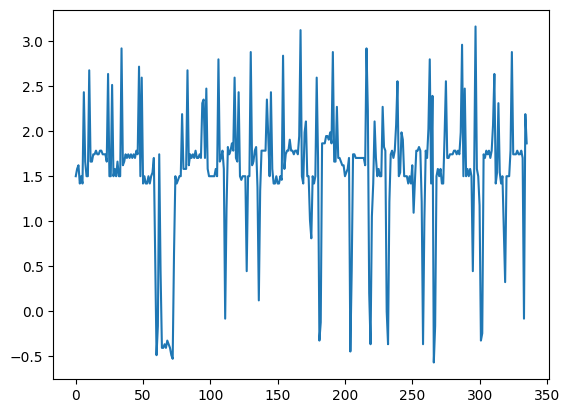

1.0 0.4555768493792184
0.9658127435505681 0.5355550740564643
0.9555877652519624 0.5065077222558919
0.9081582681007516 0.5580954507914705
0.8518803000580751 0.5756133044774804
0.8673132069244474 0.6067335225938942
0.46797151899787587 0.9227270330102433


In [197]:
from src.experiments.CiDPG import CiDPGForecast
plt.plot(x_ticks, plot_x, label='lookback')
# plt.plot(y_ticks, plot_y, label='ground_truth')
# plt.plot(y_ticks, plot_pred_y, label='prediction')
plt.show()
for i in range(0, 7):
    # print(compute_cka(exp.model.prevs[0][0].detach().cpu().numpy(), exp.model.prevs[i][0].detach().cpu().numpy()))
    print(compute_cka(exp.model.prevs[0][0].detach().cpu().numpy(), exp.model.prevs[i][0].detach().cpu().numpy()), 
          compute_cka(standardize(batch_y[0].transpose(0,1).detach().cpu().numpy()) , exp.model.prevs[i][0].detach().cpu().numpy()))
    
    # exp.model.init_embedding[0]
    
    

### ExchangeRate

In [198]:
dataset = "ExchangeRate"
from torch_timeseries.experiments import DLinearForecast, PatchTSTForecast

from src.experiments.CiDPG import CiDPGForecast

exp = CiDPGForecast(dataset_type=dataset, windows=336, horizon=1, pred_len=720, data_path='/notebooks/pytorchtimseries/data', save_dir='/notebooks/4901_revisit_cdtran/results', device='cuda:0')
exp._setup_run(1)
exp._resume_run(1)


plt.show()

# i = 1000
i = 0
batch_x, batch_y, origin_x, origin_y, batch_x_date_enc, batch_y_date_enc = map(lambda x: torch.tensor(x).to(exp.device).unsqueeze(0).float(),  exp.dataloader.test_loader.dataset[i])
pred_y, true_y  = exp._process_one_batch(batch_x, batch_y, batch_x_date_enc, batch_y_date_enc)


b = 0
v = 0

plot_x = batch_x[b, :, v].cpu().detach().numpy()
plot_y = batch_y[b, :, v].cpu().detach().numpy()
plot_pred_y = pred_y[b, :, v].cpu().detach().numpy()

x_ticks = np.arange(len(plot_x))
y_ticks = np.arange(len(plot_x), len(plot_x)+len(plot_y))

# xy_plot

Using downloaded and verified file: /notebooks/pytorchtimseries/data/ExchangeRate/exchange_rate.csv
train steps: 4256
val steps: 798
test steps: 41
tensor([128, 182, 238, 292, 348, 402, 458, 512], dtype=torch.int32)
self.t_index [95, 143, 191, 239, 287, 335, 383]
resuming from /notebooks/4901_revisit_cdtran/results/runs/CiDPG/ExchangeRate/w336h1s720/b5d8417215bf20d2f9e7ac6b5f0691fd/run_checkpoint.pth


/notebooks/pytorchtimseries/torch_timeseries/experiments/forecast.py:378: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  check_point = torch.load(run_checkpoint_filepath, map

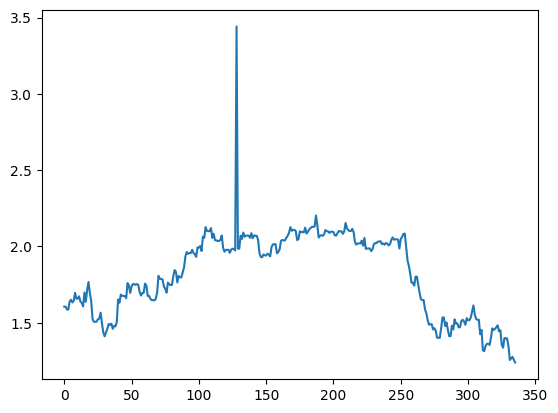

1.0 0.5070225884442033
0.8882155756629961 0.44675735936343003
0.8641027292999707 0.4202179492269441
0.8279977474782688 0.40481838268381093
0.8099399862168584 0.37674140633167524
0.7677733156777076 0.36663830022487043
0.6850248681551805 0.5522921822068216


In [199]:
from src.experiments.CiDPG import CiDPGForecast
plt.plot(x_ticks, plot_x, label='lookback')
# plt.plot(y_ticks, plot_y, label='ground_truth')
# plt.plot(y_ticks, plot_pred_y, label='prediction')
plt.show()
for i in range(0, 7):
    # print(compute_cka(exp.model.prevs[0][0].detach().cpu().numpy(), exp.model.prevs[i][0].detach().cpu().numpy()))
    print(compute_cka(exp.model.prevs[0][0].detach().cpu().numpy(), exp.model.prevs[i][0].detach().cpu().numpy()), 
          compute_cka(standardize(batch_y[0].transpose(0,1).detach().cpu().numpy()) , exp.model.prevs[i][0].detach().cpu().numpy()))
    
    # exp.model.init_embedding[0]
    
    

### Traffic

In [9]:
dataset = "Traffic"
from torch_timeseries.experiments import DLinearForecast, PatchTSTForecast

from src.experiments.PAN import PANForecast

exp = PANForecast(dataset_type=dataset, windows=336, horizon=1, pred_len=720, data_path='/notebooks/pytorchtimseries/data', save_dir='/notebooks/4901_revisit_cdtran/results', device='cuda:0')
exp._setup_run(1)
exp._resume_run(1)


plt.show()

# i = 1000
i = 0
batch_x, batch_y, origin_x, origin_y, batch_x_date_enc, batch_y_date_enc = map(lambda x: torch.tensor(x).to(exp.device).unsqueeze(0).float(),  exp.dataloader.test_loader.dataset[i])
pred_y, true_y  = exp._process_one_batch(batch_x, batch_y, batch_x_date_enc, batch_y_date_enc)


b = 0
v = 0

plot_x = batch_x[b, :, v].cpu().detach().numpy()
plot_y = batch_y[b, :, v].cpu().detach().numpy()
plot_pred_y = pred_y[b, :, v].cpu().detach().numpy()

x_ticks = np.arange(len(plot_x))
y_ticks = np.arange(len(plot_x), len(plot_x)+len(plot_y))

# xy_plot

Using downloaded and verified file: /notebooks/pytorchtimseries/data/traffic/traffic.txt.gz
Extracting /notebooks/pytorchtimseries/data/traffic/traffic.txt.gz to /notebooks/pytorchtimseries/data/traffic
train steps: 11225
val steps: 2789
test steps: 1037
tensor([128, 182, 238, 292, 348, 402, 458, 512], dtype=torch.int32)
7
self.t_index [95, 143, 191, 239, 287, 335, 383]
not raw_info..
resuming from /notebooks/4901_revisit_cdtran/results/runs/PAN/Traffic/w336h1s720/370e23cdda1472adf1d3fec3575d37d6/run_checkpoint.pth


/notebooks/pytorchtimseries/torch_timeseries/experiments/forecast.py:378: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  check_point = torch.load(run_checkpoint_filepath, map

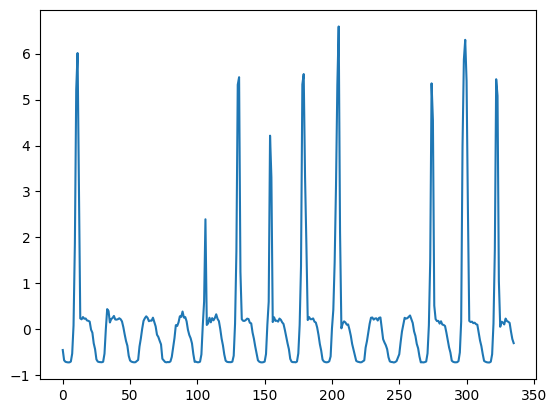

1.0 0.031081754752073296
0.8089958508505508 0.12548489392348633
0.8491989042134009 0.0666649234669069
0.8267347712258502 0.07055143947866341
0.8338565309638734 0.17947117534095036
0.20289638643636052 0.8782584717231146
0.027539646273058008 0.9335053897848715


In [10]:
from src.experiments.CiDPG import CiDPGForecast
plt.plot(x_ticks, plot_x, label='lookback')
# plt.plot(y_ticks, plot_y, label='ground_truth')
# plt.plot(y_ticks, plot_pred_y, label='prediction')
plt.show()
for i in range(0, 7):
    # print(compute_cka(exp.model.prevs[0][0].detach().cpu().numpy(), exp.model.prevs[i][0].detach().cpu().numpy()))
    print(compute_cka(exp.model.prevs[0][0].detach().cpu().numpy(), exp.model.prevs[i][0].detach().cpu().numpy()), 
          compute_cka(standardize(batch_y[0].transpose(0,1).detach().cpu().numpy()) , exp.model.prevs[i][0].detach().cpu().numpy()))
    
    # exp.model.init_embedding[0]
    
    

### Weather

In [11]:
dataset = "Weather"
from torch_timeseries.experiments import DLinearForecast, PatchTSTForecast

from src.experiments.CiDPG import CiDPGForecast

exp = CiDPGForecast(dataset_type=dataset, windows=336, horizon=1, pred_len=720, data_path='/notebooks/pytorchtimseries/data', save_dir='/notebooks/4901_revisit_cdtran/results', device='cuda:0')
exp._setup_run(1)
exp._resume_run(1)


plt.show()

# i = 1000
i = 0
batch_x, batch_y, origin_x, origin_y, batch_x_date_enc, batch_y_date_enc = map(lambda x: torch.tensor(x).to(exp.device).unsqueeze(0).float(),  exp.dataloader.test_loader.dataset[i])
pred_y, true_y  = exp._process_one_batch(batch_x, batch_y, batch_x_date_enc, batch_y_date_enc)


b = 0
v = 0

plot_x = batch_x[b, :, v].cpu().detach().numpy()
plot_y = batch_y[b, :, v].cpu().detach().numpy()
plot_pred_y = pred_y[b, :, v].cpu().detach().numpy()

x_ticks = np.arange(len(plot_x))
y_ticks = np.arange(len(plot_x), len(plot_x)+len(plot_y))

# xy_plot

Using downloaded and verified file: /notebooks/pytorchtimseries/data/weather/weather.zip
Extracting /notebooks/pytorchtimseries/data/weather/weather.zip to /notebooks/pytorchtimseries/data/weather
train steps: 35832
val steps: 9820
test steps: 4551
tensor([128, 182, 238, 292, 348, 402, 458, 512], dtype=torch.int32)
self.t_index [95, 143, 191, 239, 287, 335, 383]
resuming from /notebooks/4901_revisit_cdtran/results/runs/CiDPG/Weather/w336h1s720/41529a3a69e86c0a99184512abe6781b/run_checkpoint.pth


/notebooks/pytorchtimseries/torch_timeseries/experiments/forecast.py:378: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  check_point = torch.load(run_checkpoint_filepath, map

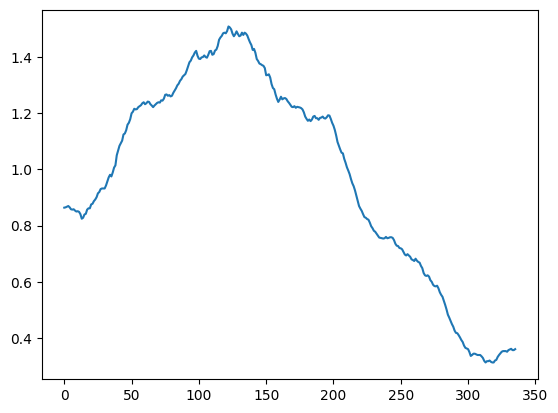

1.0 0.4423978719794836
0.8531324261398092 0.4720707794623067
0.8187821475162615 0.44443357341946793
0.8454019241680346 0.5052373298743548
0.6692661009288352 0.5978878609375496
0.7076089100474209 0.5193771623106012
0.34303278502407625 0.7872344411277052


In [12]:
from src.experiments.CiDPG import CiDPGForecast
plt.plot(x_ticks, plot_x, label='lookback')
# plt.plot(y_ticks, plot_y, label='ground_truth')
# plt.plot(y_ticks, plot_pred_y, label='prediction')
plt.show()
for i in range(0, 7):
    # print(compute_cka(exp.model.prevs[0][0].detach().cpu().numpy(), exp.model.prevs[i][0].detach().cpu().numpy()))
    print(compute_cka(exp.model.prevs[0][0].detach().cpu().numpy(), exp.model.prevs[i][0].detach().cpu().numpy()), 
          compute_cka(standardize(batch_y[0].transpose(0,1).detach().cpu().numpy()) , exp.model.prevs[i][0].detach().cpu().numpy()))
    
    # exp.model.init_embedding[0]
    
    

NameError: name 'ExchangeRate' is not defined

### PEMS04

In [48]:
dataset = "PEMS04"
from src.experiments.shortterm.CiDPG import CiDPGForecast

exp = CiDPGForecast(dataset_type=dataset, windows=96, horizon=1, pred_len=12, data_path='/notebooks/pytorchtimseries/data', save_dir='/notebooks/4901_revisit_cdtran/results', device='cuda:0')
exp._setup_run(1)
exp._resume_run(1)


plt.show()

# i = 1000
i = 10
batch_x, batch_y, origin_x, origin_y, batch_x_date_enc, batch_y_date_enc = map(lambda x: torch.tensor(x).to(exp.device).unsqueeze(0).float(),  exp.dataloader.test_loader.dataset[i])
pred_y, true_y  = exp._process_one_batch(batch_x, batch_y, batch_x_date_enc, batch_y_date_enc)


b = 0
v = 0

plot_x = batch_x[b, :, v].cpu().detach().numpy()
plot_y = batch_y[b, :, v].cpu().detach().numpy()
plot_pred_y = pred_y[b, :, v].cpu().detach().numpy()

x_ticks = np.arange(len(plot_x))
y_ticks = np.arange(len(plot_x), len(plot_x)+len(plot_y))

# xy_plot

train steps: 11787
val steps: 3387
test steps: 1689
tensor([128, 320, 512], dtype=torch.int32)
self.t_index [95, 143]
resuming from /notebooks/4901_revisit_cdtran/results/runs/CiDPG/PEMS04/w96h1s12/eabffba5fc558a7ee339bdd7fe3455e4/run_checkpoint.pth


/notebooks/pytorchtimseries/torch_timeseries/experiments/forecast.py:378: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  check_point = torch.load(run_checkpoint_filepath, map

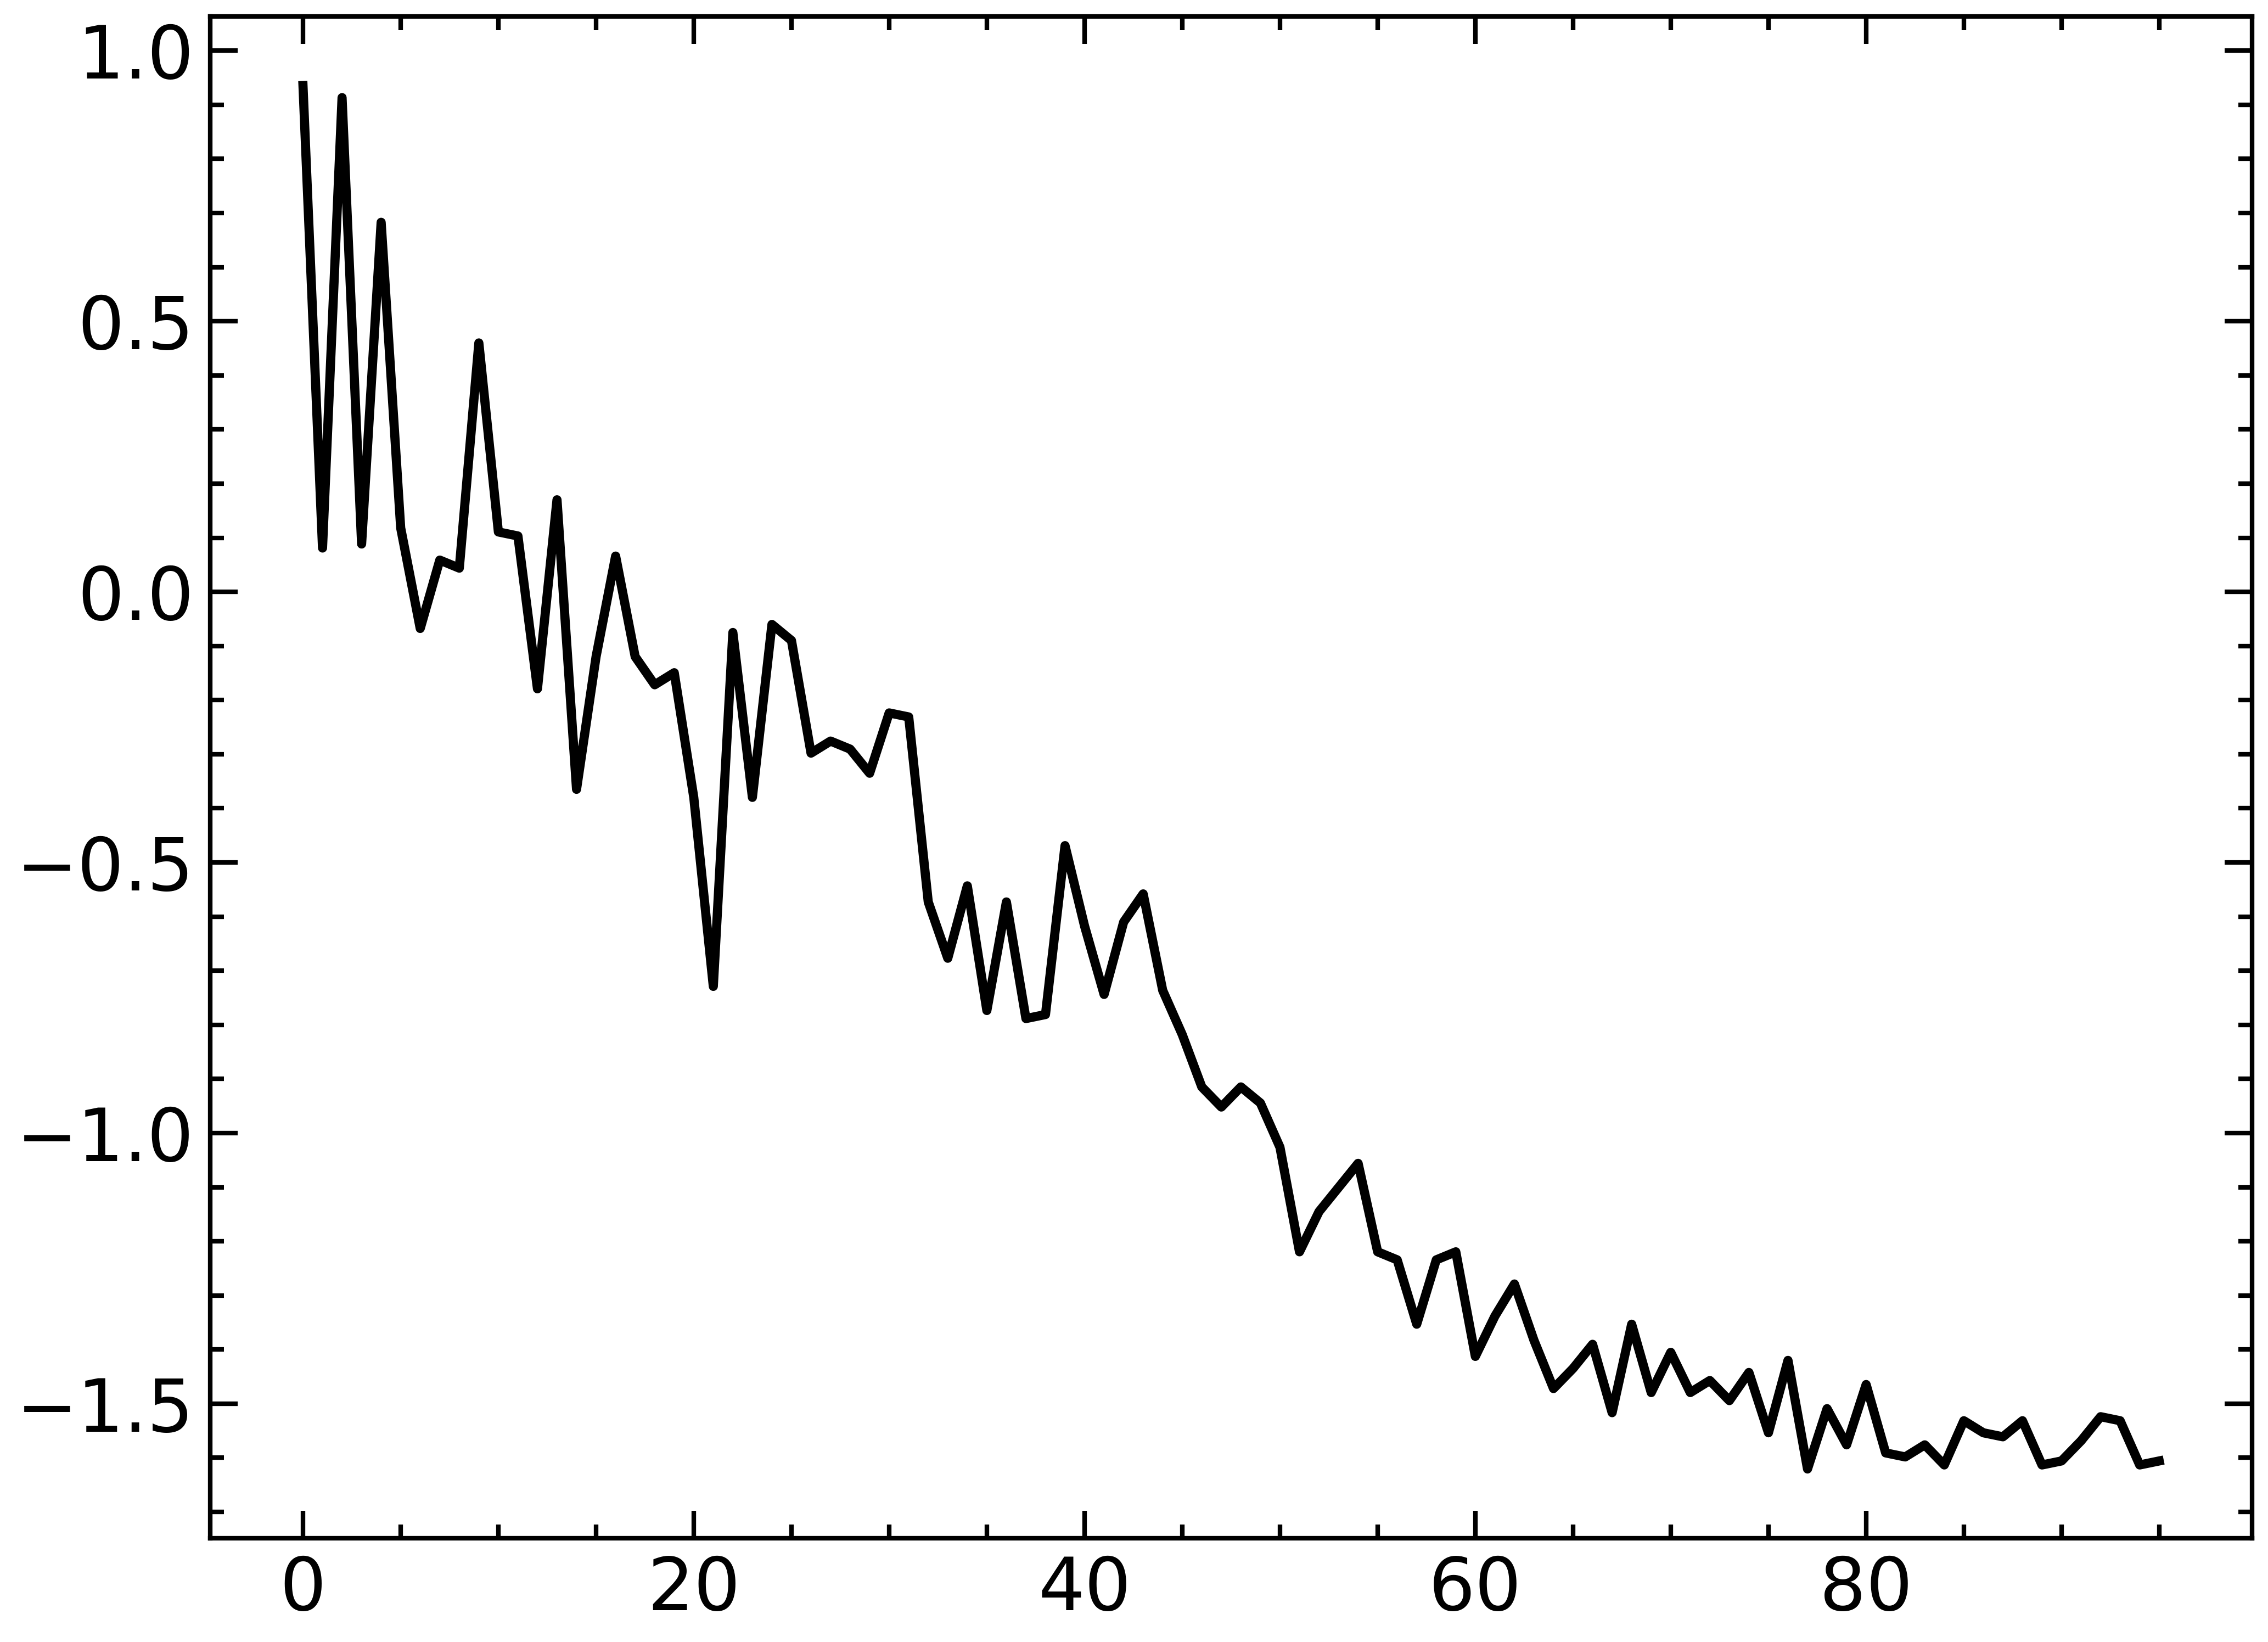

1.0 0.22983847629238532
0.6494548092682162 0.1893444404437548


IndexError: list index out of range

In [49]:
plt.plot(x_ticks, plot_x, label='lookback')
# plt.plot(y_ticks, plot_y, label='ground_truth')
# plt.plot(y_ticks, plot_pred_y, label='prediction')
plt.show()
for i in range(0, 3):
    # print(compute_cka(exp.model.prevs[0][0].detach().cpu().numpy(), exp.model.prevs[i][0].detach().cpu().numpy()))
    print(compute_cka(exp.model.prevs[0][0].detach().cpu().numpy(), exp.model.prevs[i][0].detach().cpu().numpy()), 
          compute_cka(standardize(batch_y[0].transpose(0,1).detach().cpu().numpy()) , exp.model.prevs[i][0].detach().cpu().numpy()))
    
    # exp.model.init_embedding[0]
    
    

# Plot

In [6]:
plt.style.use(['science', 'ieee', 'notebook'])

## ETT

In [7]:
etth1_str = """
1.0 0.6726167160796801
0.9211184884111563 0.5908949644898076
0.8348669273726101 0.5480234163070126
0.8168922848634003 0.4975571575598399
0.7883129748749167 0.5865042644773983
0.9498860396955562 0.7115725605854225
0.8088318286757638 0.9096738138424695
"""
etth2_str = """
1.0 0.6393106702014503
0.9532140433120384 0.5971223414449202
0.9385903096577748 0.6926729714262925
0.9058354512562704 0.7546694427244285
0.8847435128425178 0.8079246206545276
0.9222705284260281 0.7044103794533159
0.6706138987453633 0.756887103452439
"""
ettm1_str = """
1.0 0.46618016480748914
0.9319610196292578 0.541110819603167
0.7210298650602122 0.6753151077053451
0.7709363933995932 0.790844910418796
0.7167497340622673 0.7402117478101599
0.7943135921221114 0.8183922090962313
0.5007708863459291 0.8583458947173959
"""

ettm2_str = """
1.0 0.0006236967937916374
0.974849363028893 0.009321159599221302
0.003019572611074733 0.5660322100189978
0.0037843846628097936 0.7096674937107577
0.004163882231675368 0.6361544725609665
0.015467545811714998 0.6876097433671953
-0.0008232508956227515 0.7751522448653254
"""


def parse_str(s):
    input_str = s.strip()
    lines = input_str.split('\n')

    array1 = []
    array2 = []
    for line in lines:
        parts = line.split()
        array1.append(float(parts[0]))
        array2.append(float(parts[1]))
    return array1, array2
etth1_1st, etth1_pred = parse_str(etth1_str)
etth2_1st, etth2_pred = parse_str(etth2_str)
ettm1_1st, ettm1_pred = parse_str(ettm1_str)
ettm2_1st, ettm2_pred = parse_str(ettm2_str)

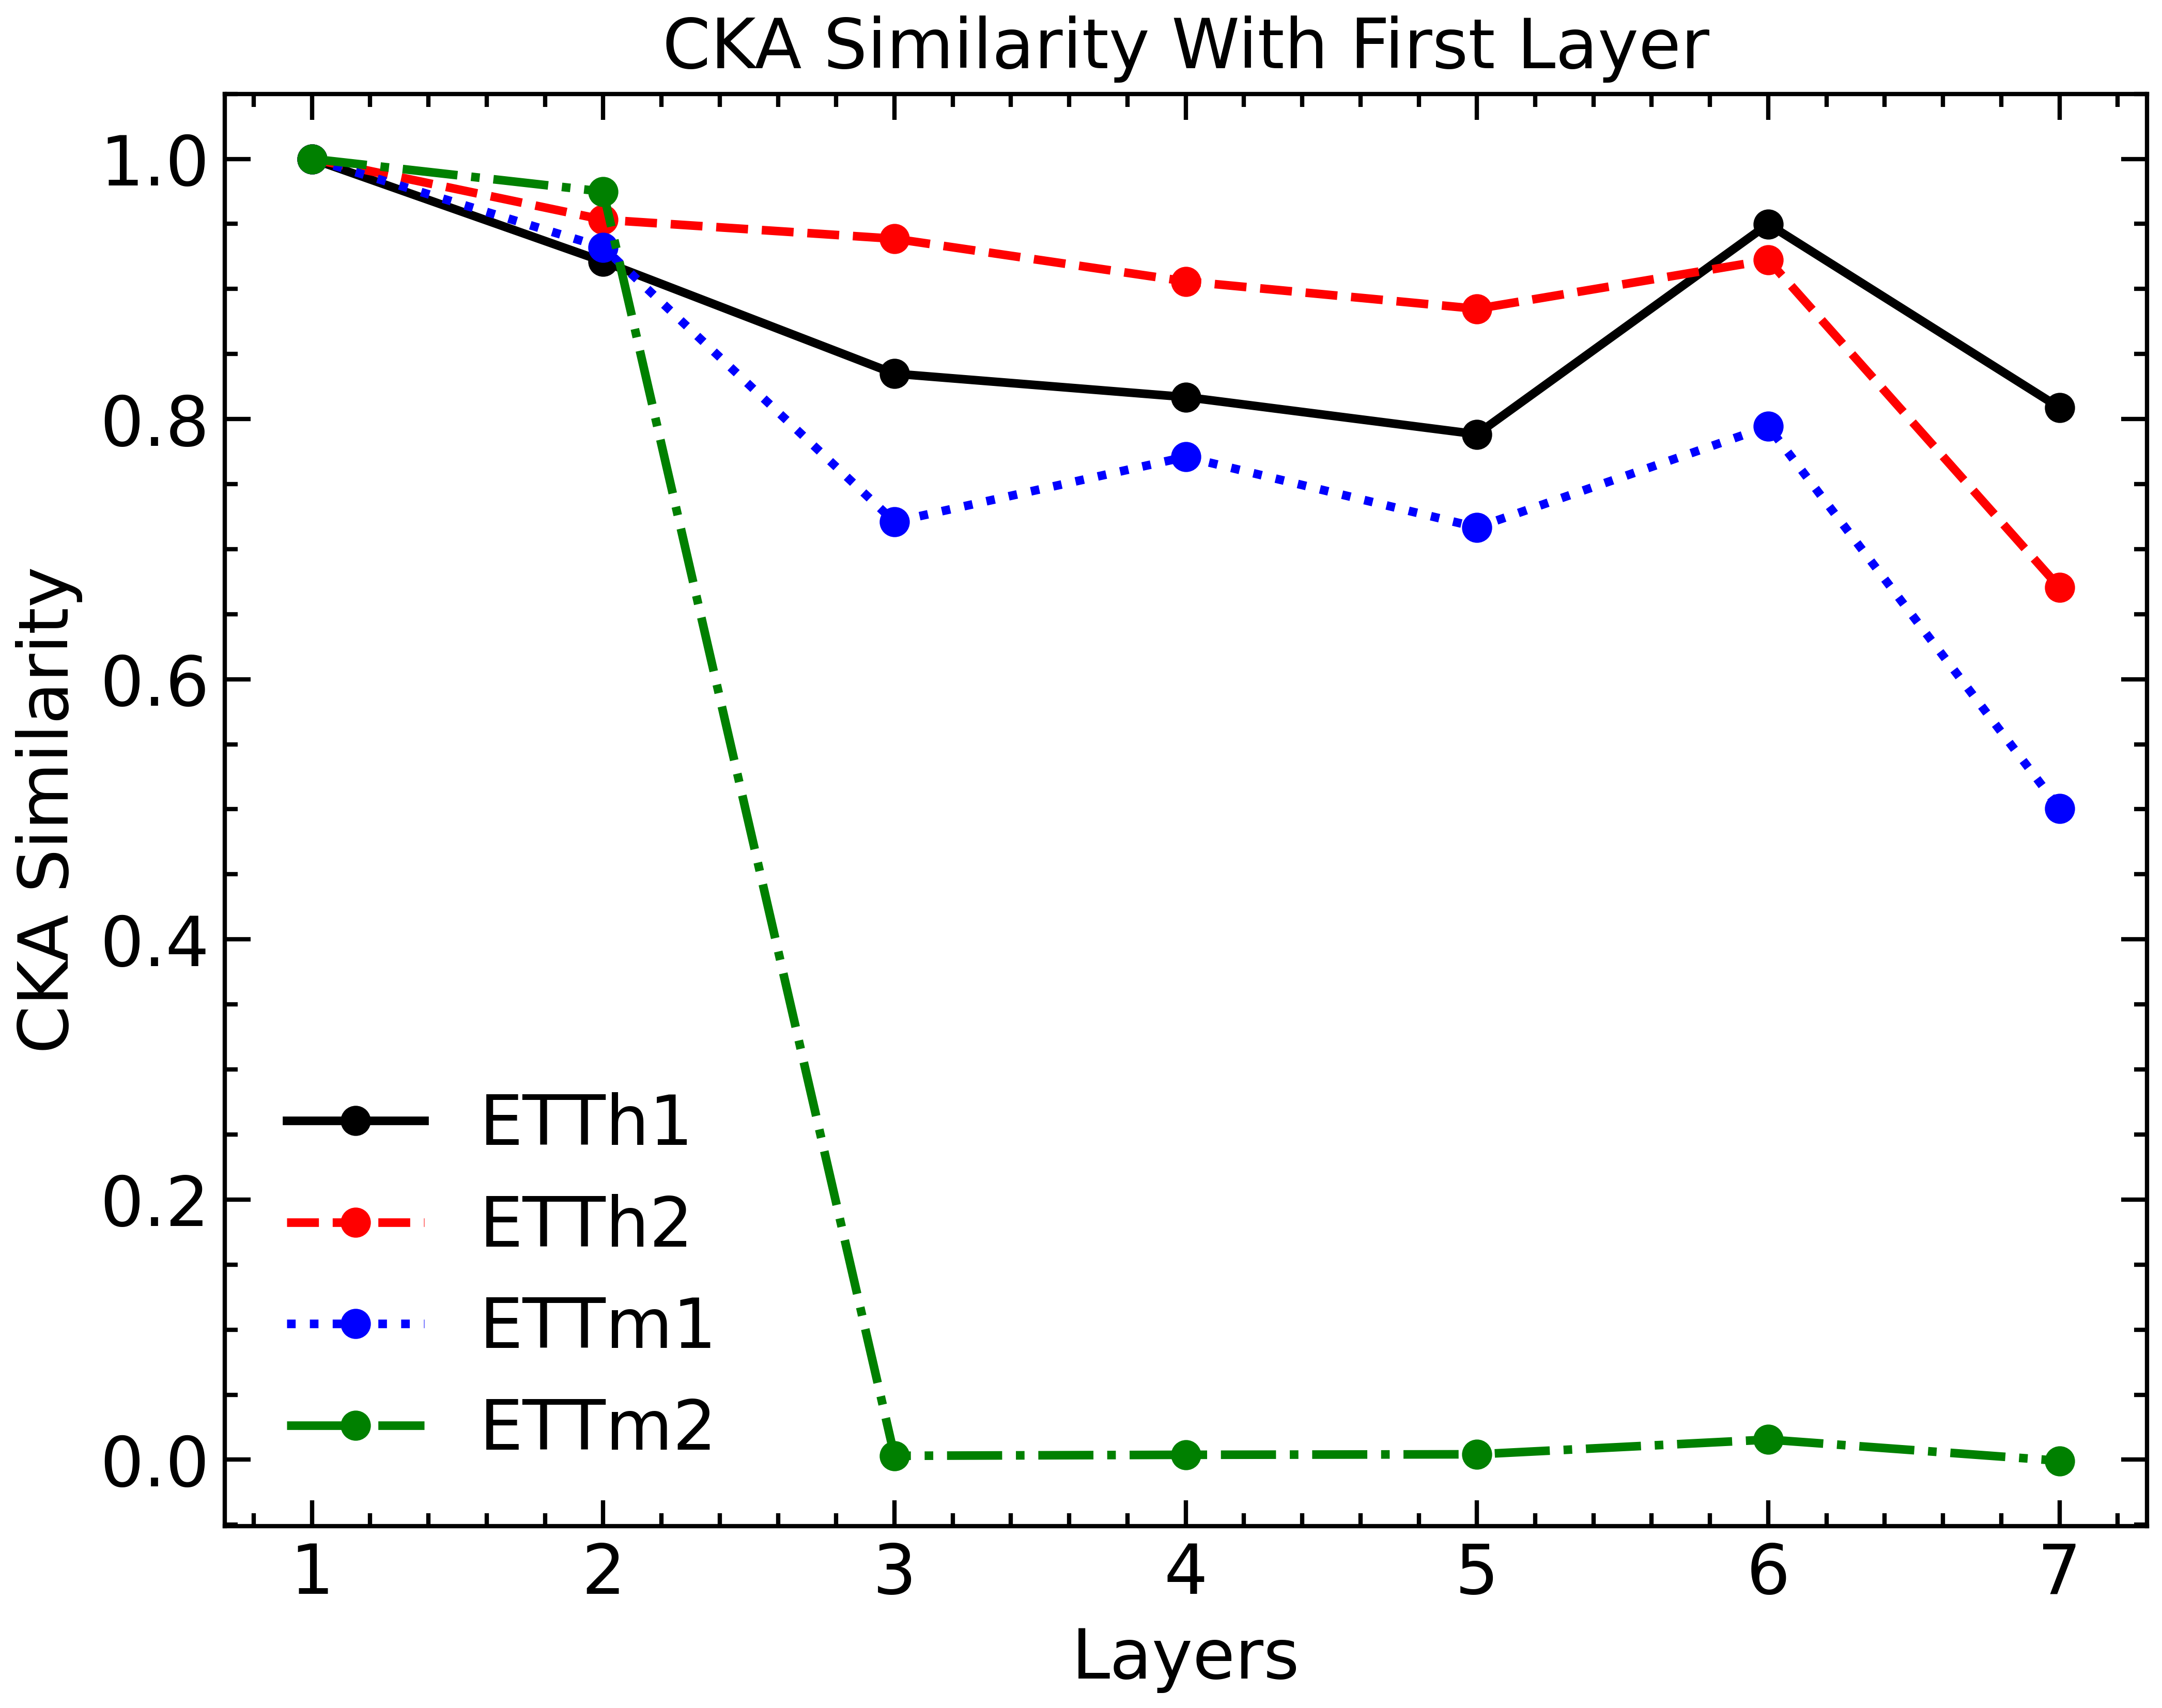

In [8]:
# plt.plot([etth1_1st, etth2_1st, ettm1_1st, ettm2_1st])

plt.figure()
x = list(range(1, 8))  # Line numbers for x-axis
plt.plot(x, etth1_1st, label="ETTh1", marker='o')
plt.plot(x, etth2_1st, label="ETTh2", marker='o')
plt.plot(x, ettm1_1st, label="ETTm1", marker='o')
plt.plot(x, ettm2_1st, label="ETTm2", marker='o')

plt.title('CKA Similarity With First Layer')
plt.ylabel('CKA Similarity')
plt.xlabel('Layers')
plt.legend()



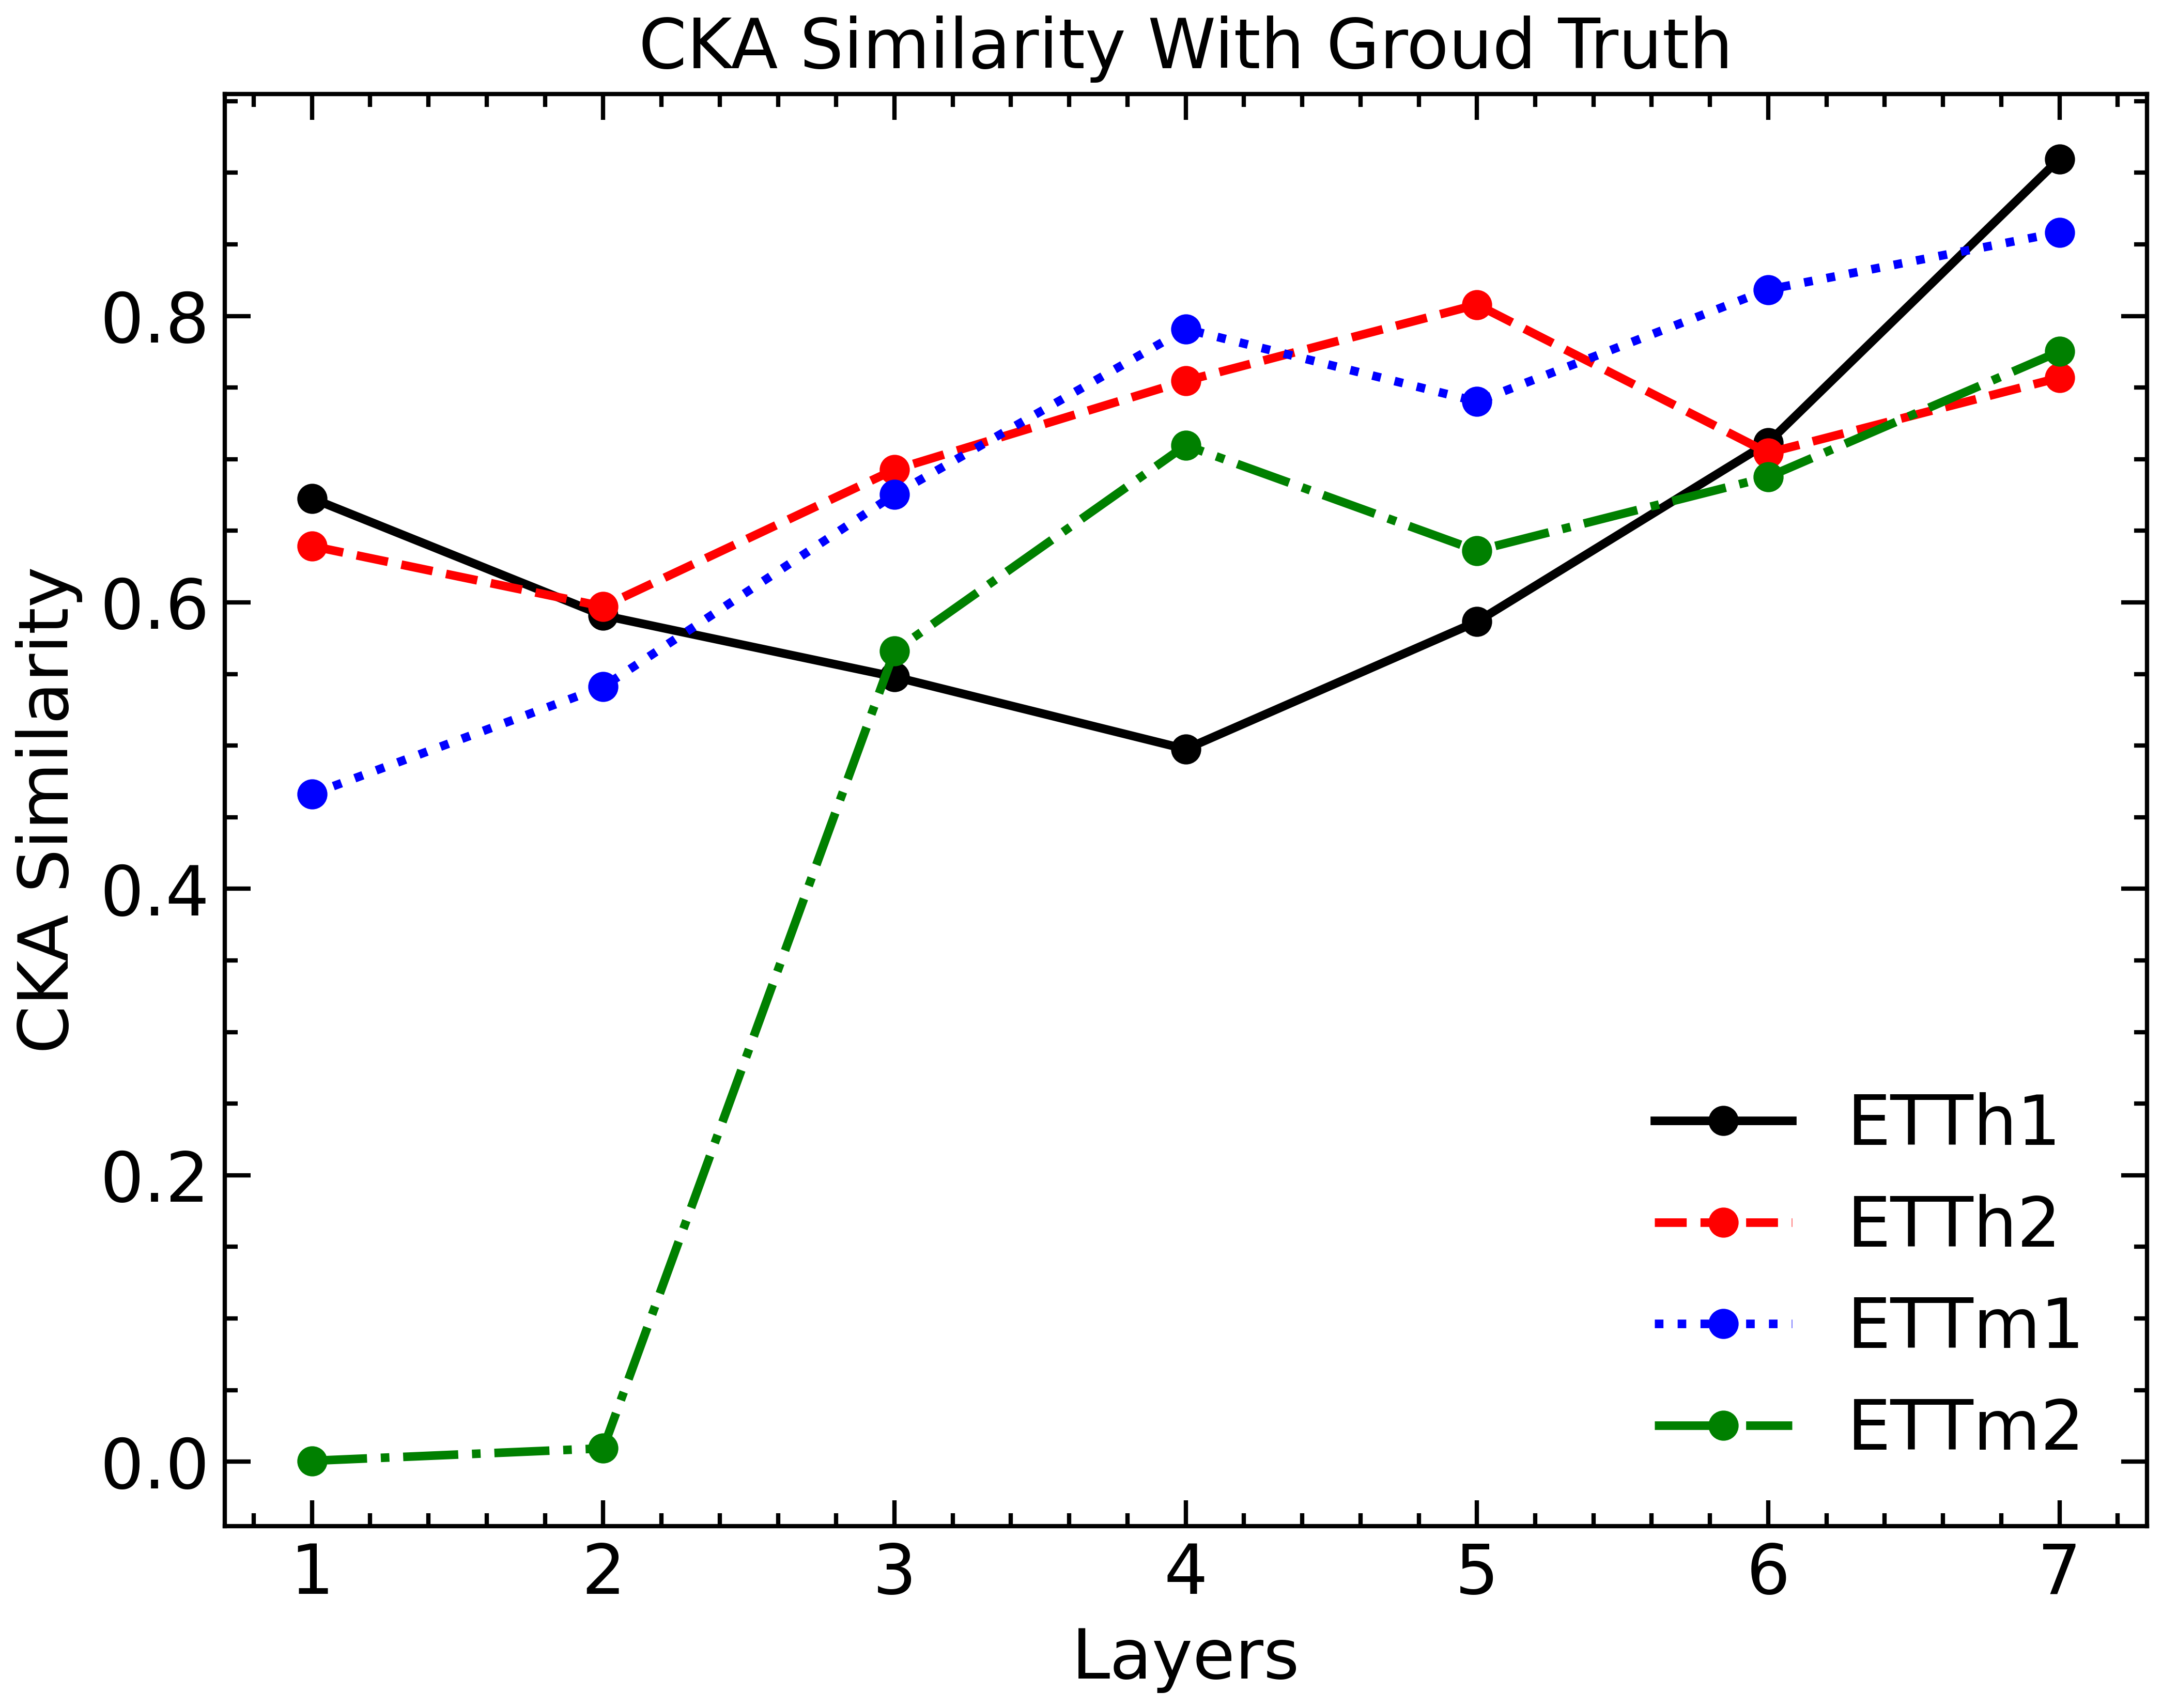

In [35]:
plt.plot(x, etth1_pred, label="ETTh1", marker='o')
plt.plot(x, etth2_pred, label="ETTh2", marker='o')
plt.plot(x, ettm1_pred, label="ETTm1", marker='o')
plt.plot(x, ettm2_pred, label="ETTm2", marker='o')



plt.title('CKA Similarity With Groud Truth')
plt.ylabel('CKA Similarity')
plt.xlabel('Layers')
plt.legend()


## Other

In [40]:
electricity_str = """
1.0 0.4555768493792184
0.9658127435505681 0.5355550740564643
0.9555877652519624 0.5065077222558919
0.9081582681007516 0.5580954507914705
0.8518803000580751 0.5756133044774804
0.8673132069244474 0.6067335225938942
0.46797151899787587 0.9227270330102433
"""
exchange_str = """
1.0 0.5070225884442033
0.8882155756629961 0.44675735936343003
0.8641027292999707 0.4202179492269441
0.8279977474782688 0.40481838268381093
0.8099399862168584 0.37674140633167524
0.7677733156777076 0.36663830022487043
0.6850248681551805 0.5522921822068216
"""
traffic_str = """
1.0 0.031081754752073296
0.8089958508505508 0.12548489392348633
0.8491989042134009 0.0666649234669069
0.8267347712258502 0.07055143947866341
0.8338565309638734 0.17947117534095036
0.20289638643636052 0.8782584717231146
0.027539646273058008 0.9335053897848715
"""

weather_str = """
1.0 0.4423978719794836
0.8531324261398092 0.4720707794623067
0.8187821475162615 0.44443357341946793
0.8454019241680346 0.5052373298743548
0.6692661009288352 0.5978878609375496
0.7076089100474209 0.5193771623106012
0.34303278502407625 0.7872344411277052
"""


def parse_str(s):
    input_str = s.strip()
    lines = input_str.split('\n')

    array1 = []
    array2 = []
    for line in lines:
        parts = line.split()
        array1.append(float(parts[0]))
        array2.append(float(parts[1]))
    return array1, array2
electricity_1st, electricity_pred = parse_str(electricity_str)
exchange_1st, exchange_pred = parse_str(exchange_str)
traffic_1st, traffic_pred = parse_str(traffic_str)
weather_1st, weather_pred = parse_str(weather_str)

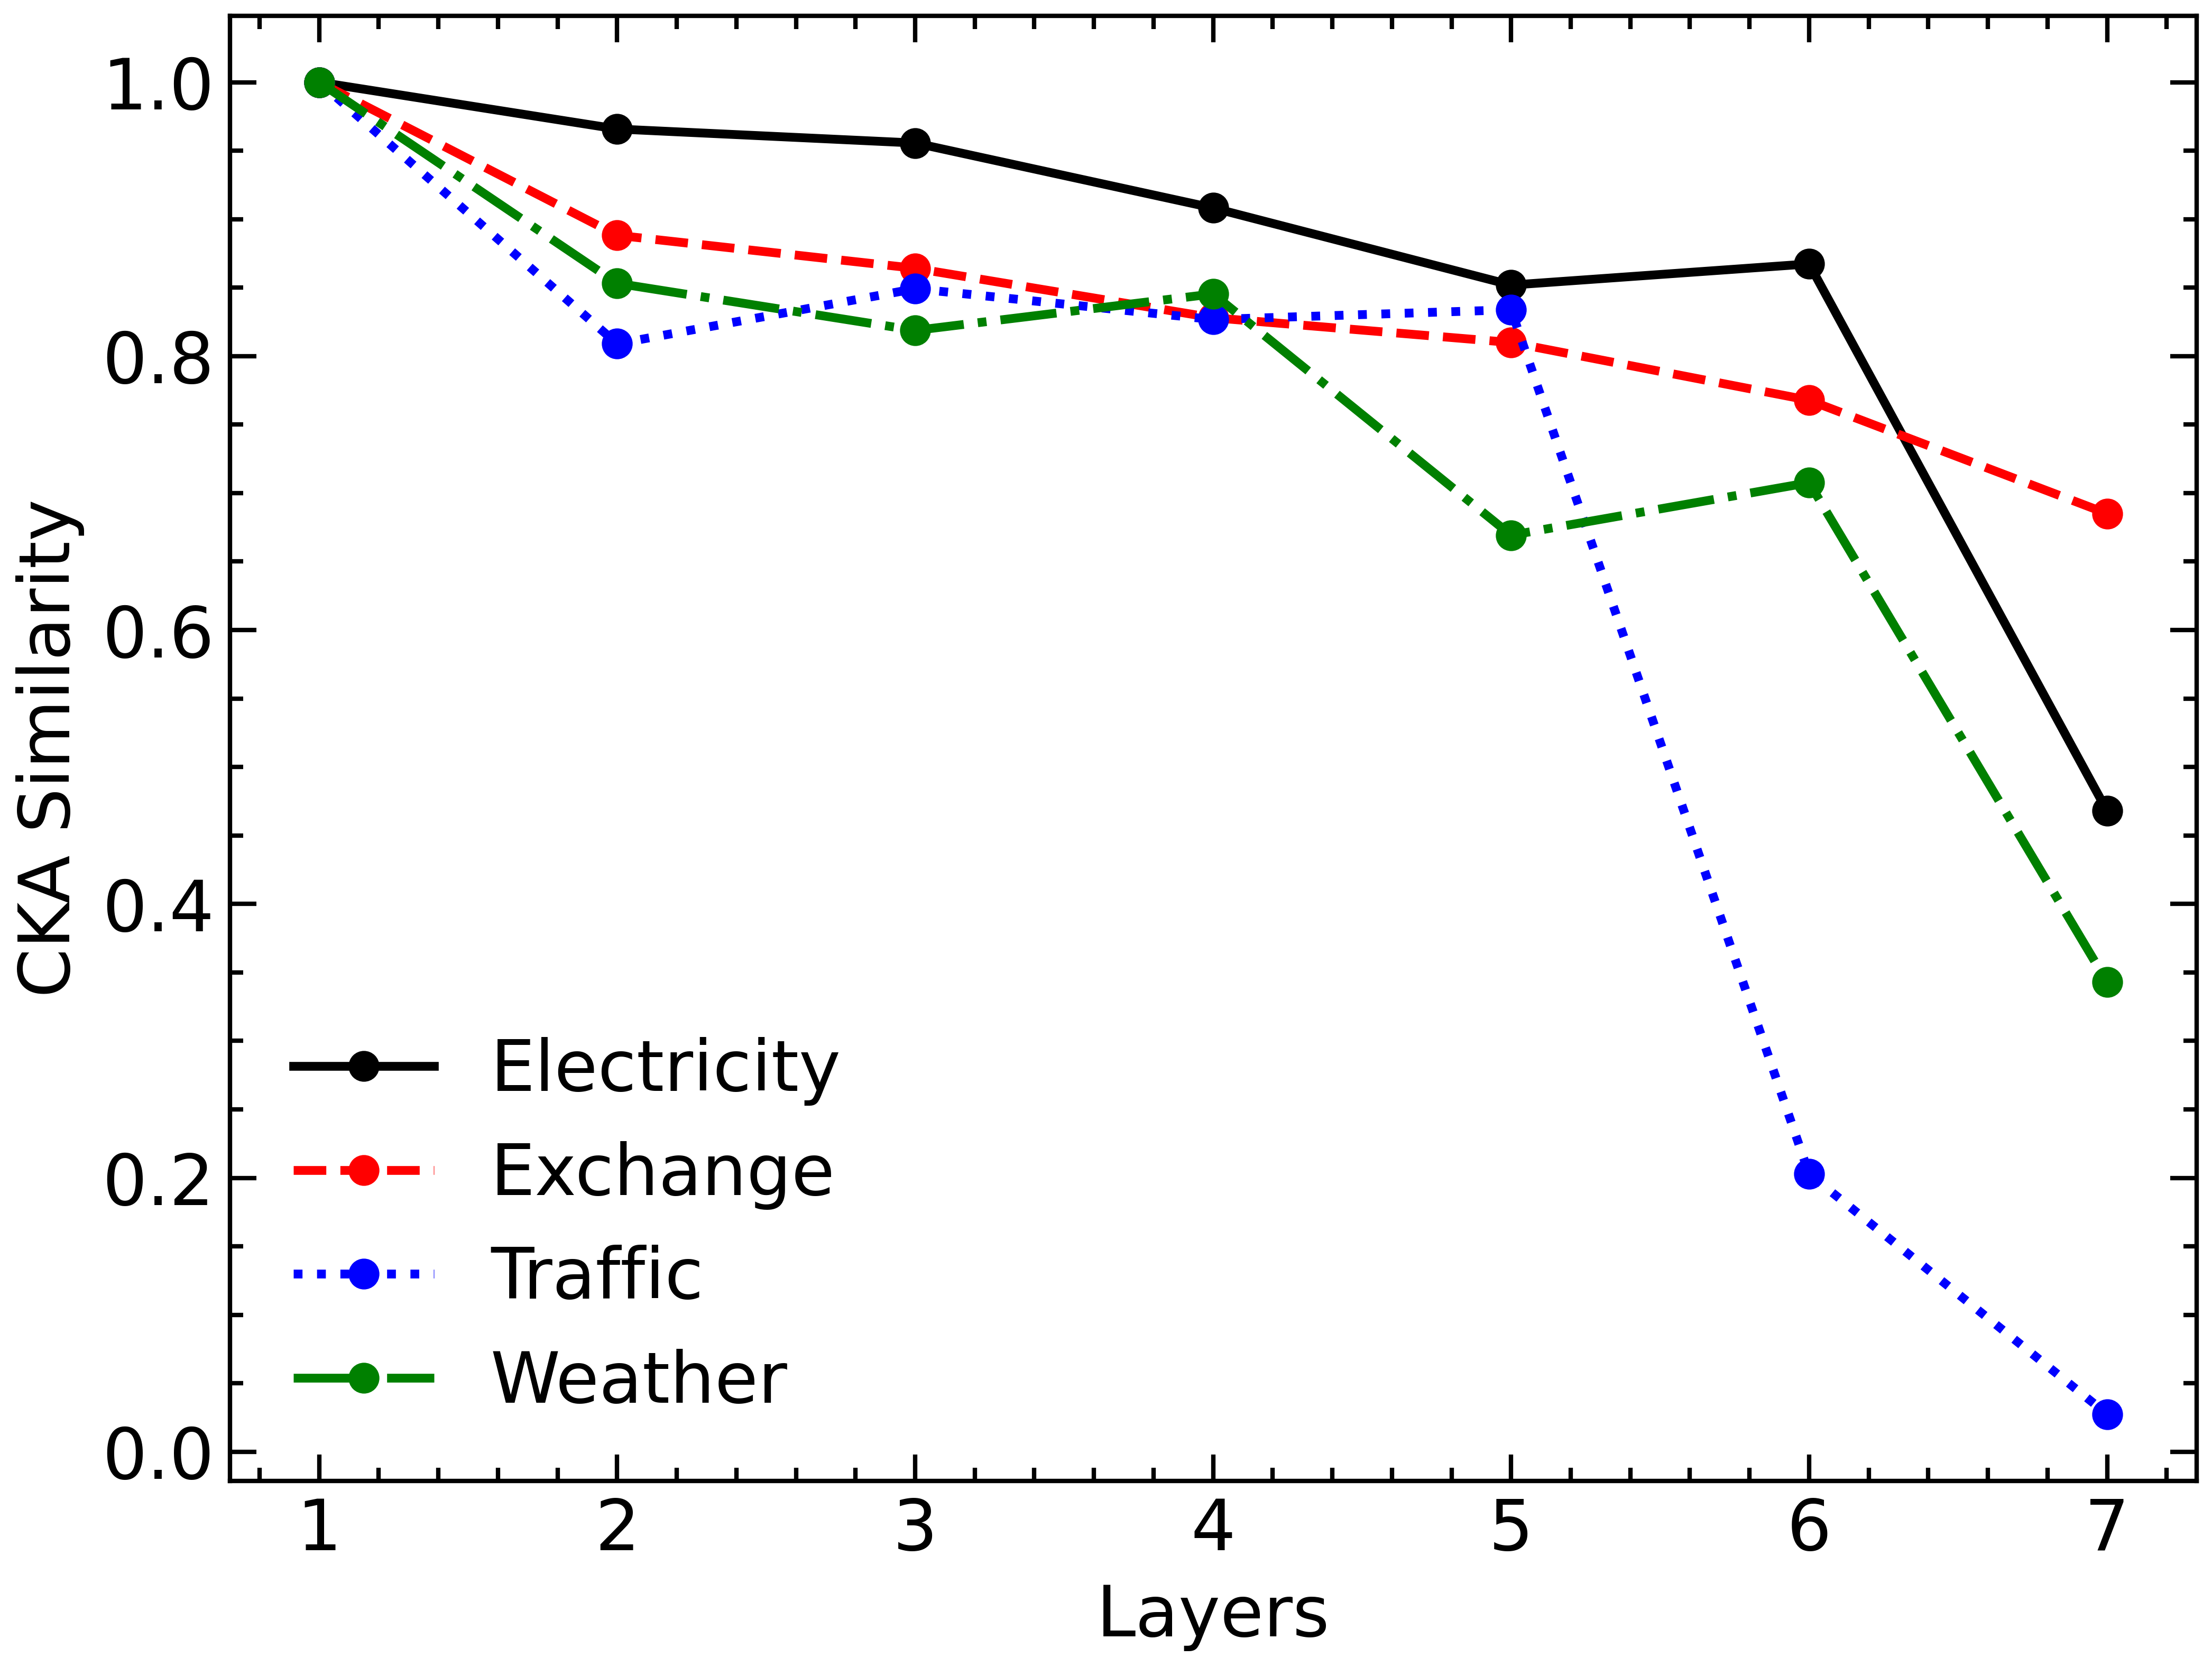

In [42]:
# plt.plot([etth1_1st, etth2_1st, ettm1_1st, ettm2_1st])

plt.figure()
x = list(range(1, 8))  # Line numbers for x-axis
plt.plot(x, electricity_1st, label="Electricity", marker='o')
plt.plot(x, exchange_1st, label="Exchange", marker='o')
plt.plot(x, traffic_1st, label="Traffic", marker='o')
plt.plot(x, weather_1st, label="Weather", marker='o')

# plt.title('CKA Similarity With First Layer')
plt.ylabel('CKA Similarity')
plt.xlabel('Layers')
plt.legend()



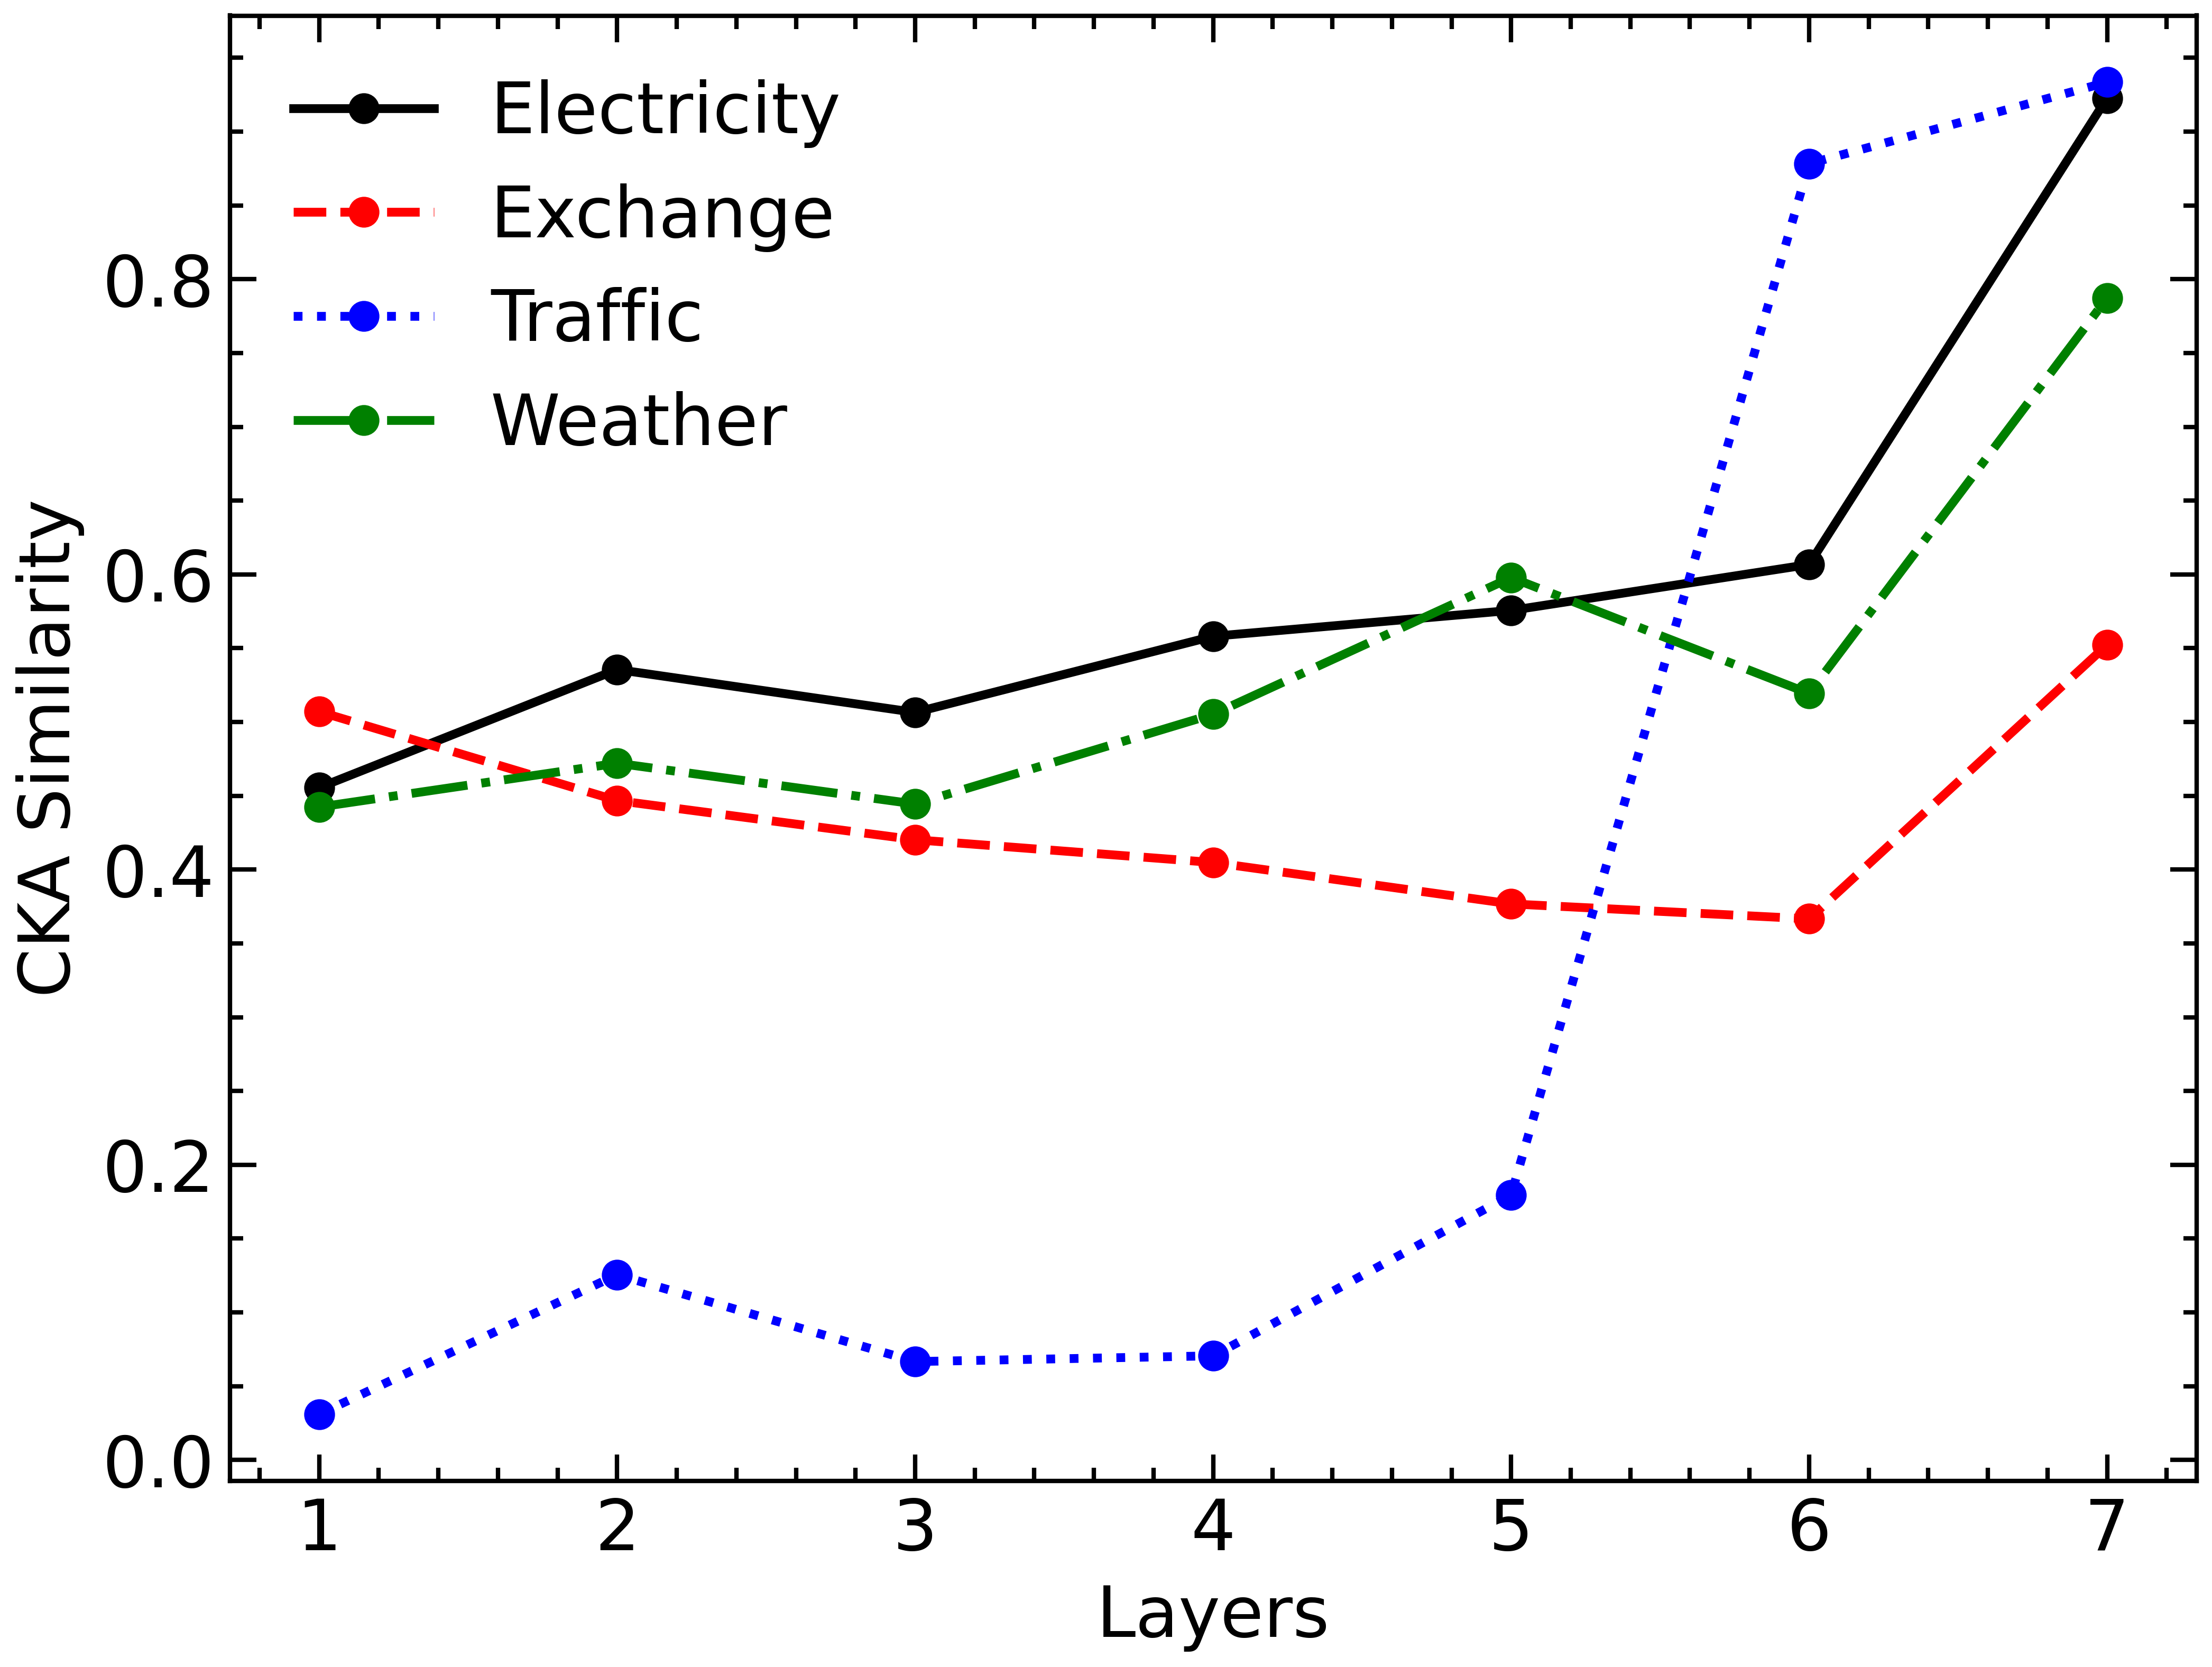

In [41]:
plt.plot(x, electricity_pred, label="Electricity", marker='o')
plt.plot(x, exchange_pred, label="Exchange", marker='o')
plt.plot(x, traffic_pred, label="Traffic", marker='o')
plt.plot(x, weather_pred, label="Weather", marker='o')



# plt.title('CKA Similarity With Groud Truth')
plt.ylabel('CKA Similarity')
plt.xlabel('Layers')
plt.legend()


## Short-term spatial-temporal